<a href="https://colab.research.google.com/github/Michel-p16/PDS-Project/blob/Murat/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ReadTheDocs
https://pds-project.readthedocs.io/en/latest/

# Imports

In [1]:
!pip install -q transformers datasets scikit-learn matplotlib seaborn google-generativeai accelerate peft bitsandbytes

import os
import json
import time
import datetime
import re
import pickle
import random
import shutil
from collections import defaultdict

from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, hamming_loss, jaccard_score, matthews_corrcoef

from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DistilBertForSequenceClassification, EarlyStoppingCallback

import google.generativeai as genai

from peft import LoraConfig, get_peft_model
import accelerate

import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from PIL import Image
import ipywidgets as widgets
from IPython.display import display


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.environ["WANDB_DISABLED"] = "true"

In [4]:
path = "drive/MyDrive/CapStone_models"

os.makedirs(path, exist_ok=True)

# Data Extraction

Please upload the provided questionnaires to the colab runtime before running the following code.

In [ ]:
filenames = ["questionnaire1.json", "questionnaire2.json", "questionnaire3.json", "questionnaire4.json", "questionnaire5.json"]

merged_data = []

for filename in filenames:
    if filename.endswith(".json"):

        with open(filename, "r", encoding="utf-8") as file:
            json_data = json.load(file)
            merged_data.extend(json_data)

with open("merged_questionnaires.json", "w", encoding="utf-8") as output_file:
    json.dump(merged_data, output_file, indent=4)

print("Merged JSON data with all information saved successfully!")

Merged JSON data with all information saved successfully!


In [ ]:
with open("merged_questionnaires.json", "r", encoding="utf-8") as file:
    json_data = json.load(file)

data = []
for entry in json_data:
    question_type = entry["type"]
    question = entry["question"]
    for option in entry["options"]:
        data.append([question_type, question, option["option"]])

df_questionnaires = pd.DataFrame(data, columns=["Type", "Question", "Label"])
print(df_questionnaires)


              Type                 Question                           Label
0    SINGLE_SELECT  Data processing consent                             Yes
1    SINGLE_SELECT  Data processing consent                              No
2    SINGLE_SELECT           Customer group                        End User
3    SINGLE_SELECT           Customer group         Wholesaler, Distributor
4    SINGLE_SELECT           Customer group  Consultant, Planner, Architect
..             ...                      ...                             ...
111   MULTI_SELECT  Searches a solution for        Improve CRM data quality
112   MULTI_SELECT  Searches a solution for     Capture trade fair contacts
113  SINGLE_SELECT               Next steps                           Offer
114  SINGLE_SELECT               Next steps                         Meeting
115  SINGLE_SELECT               Next steps                            Call

[116 rows x 3 columns]


In [ ]:
df_single_select_questions = df_questionnaires[df_questionnaires["Type"] == "SINGLE_SELECT"]
#df_single_select_questions

In [ ]:
df_multi_select_questions = df_questionnaires[df_questionnaires["Type"] == "MULTI_SELECT"]
#df_multi_select_questions

# Generating Data with Gemini

In [ ]:
api_key = input("Enter your Google Generative AI API key: ").strip()
genai.configure(api_key=api_key)
print(api_key)

In [ ]:
def api_call_for_generating_question(question):
    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        prompt = f"Generate a full understandable and short question based on the following: {question}. Direct the message to me. Print the question only!"
        response = model.generate_content(prompt)
        #print(response.text.strip())
        return response.text.strip()
    except Exception as e:
        print(f"Error with Gemini API: {e}")
        return prompt

In [ ]:
def generate_question(df):
    generated_questions = dict()

    for question in df["Question"]:
        #print(question)

        if question not in generated_questions.keys():
            full_question = api_call_for_generating_question(question)
            generated_questions[question] = full_question
            #print(f"{question}: {full_question}")
            time.sleep(3)

    df['Question'] = df['Question'].map(generated_questions)
    print("Questions in dataframe with new Questions replaced.")

    return df

In [ ]:
df_single_select_questions = generate_question(df_single_select_questions)

In [ ]:
df_single_select_questions

,Type,Question,Label
0,SINGLE_SELECT,Do you consent to the processing of your data?,Yes
1,SINGLE_SELECT,Do you consent to the processing of your data?,No
2,SINGLE_SELECT,What is your customer group?,End User
3,SINGLE_SELECT,What is your customer group?,"Wholesaler, Distributor"
4,SINGLE_SELECT,What is your customer group?,"Consultant, Planner, Architect"
5,SINGLE_SELECT,What is your customer group?,R&D
29,SINGLE_SELECT,Want marketing emails from me?,Yes
30,SINGLE_SELECT,Want marketing emails from me?,No
31,SINGLE_SELECT,What industry are you in?,Aerospace
32,SINGLE_SELECT,What industry are you in?,Computers & Networks


In [ ]:
df_multi_select_questions = generate_question(df_multi_select_questions)

In [ ]:
df_multi_select_questions

,Type,Question,Label
6,MULTI_SELECT,Products interested in,MY-SYSTEM
7,MULTI_SELECT,Products interested in,Notion
8,MULTI_SELECT,Products interested in,JTS
9,MULTI_SELECT,Products interested in,JS EcoLine
10,MULTI_SELECT,Products interested in,AKW100
11,MULTI_SELECT,Products interested in,AX100
12,MULTI_SELECT,What kind of follow up is planned,Email
13,MULTI_SELECT,What kind of follow up is planned,Phone
14,MULTI_SELECT,What kind of follow up is planned,Schedule a Visit
15,MULTI_SELECT,What kind of follow up is planned,No action


In [ ]:
def make_api_call_for_answers(question, label, type):
    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        prompt = f"Generate 100 full diverse answers as one sentence split in rows for the following context '{question}' with the answer label : '{label}'. Print the answers ONLY. If the label is yes or no also include answers without the label."

        if type == "MULTI_SELECT":
            prompt = f"Generate 100 full diverse answers as one sentence split in rows for the following context '{question}' with the possible answer labels : '{label}'. Consider that multiple labels can be selected for answering, so include answers with all the possible combinations. Print in the generated answer followd up by the used labels in brackets ONLY. Also include answers without the label. Do not print additional information."

        response = model.generate_content(prompt)
        print(f"Answers for Question \"{question}\" with label \"{label}\" generated.")
        return response.text.strip()
    except Exception as e:
        print(f"Error with Gemini API: {e}")
        return prompt

In [ ]:
def generate_diverse_answers(df):

    generated_answers = []
    processed_questions = set()

    for _, row in df.iterrows():

        type = row["Type"]
        question = row["Question"]

        if type == "SINGLE_SELECT":

            label = row["Label"]

            answers = make_api_call_for_answers(question, label, type=type)

            each_response = answers.split("\n")

            for curr_response in each_response:
                    generated_answers.append({
                        #'question_id': row['question_id'],
                        'question': question,
                        'type': type,
                        'answer_text': curr_response,
                        'answer_label': label,
                        'timestamp': datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")  # Aktueller Timestamp
                    })

            time.sleep(3)

        else:

            for _, row in df.iterrows():

                labels = df[df['Question'] == question]['Label'].tolist()

                if question not in processed_questions:

                    processed_questions.add(question)

                    answers = make_api_call_for_answers(question, labels, type=type)

                    answers_with_tags = []
                    pattern = r'^(.*?)\s+\[([^\]]+)\]$'

                    for answer in answers.split("\n"):

                        match = re.match(pattern, answer)

                        try:

                            if match is not None:
                                answers_with_tags.append({
                                "answer": match.group(1),
                                "label": match.group(2)
                                })
                        except AttributeError as e:
                            print(f"Caught an exception: {e}")

                    for row in answers_with_tags:
                        generated_answers.append({
                                'question': question,
                                'type': type,
                                'answer_text': row["answer"],
                                'answer_label': row["label"],
                                'timestamp': datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")
                        })

                    time.sleep(3)

    return generated_answers

In [ ]:
df_single_select_with_new_q_and_a = generate_diverse_answers(df_single_select_questions)

In [ ]:
df_single_select_with_new_q_and_a

In [ ]:
df_multi_select_with_new_q_and_a = generate_diverse_answers(df_multi_select_questions)

In [ ]:
for item in df_multi_select_with_new_q_and_a:
    item['answer_label'] = item['answer_label'].replace('/', ',')

In [ ]:
def save_in_json(data, filename):
    grouped_data = defaultdict(lambda: {'type': None, 'answers': []})

    for entry in data:
        question = entry['question']
        if grouped_data[question]['type'] is None:
            grouped_data[question]['type'] = entry['type']
        grouped_data[question]['answers'].append({
            'answer_text': entry['answer_text'],
            'answer_label': entry['answer_label'].replace("  ", " ").strip(),
            'timestamp': entry['timestamp']
        })

    final_json = [
        {
            'question': question,
            'type': details['type'],
            'answers': details['answers']
        }
        for question, details in grouped_data.items()
    ]

    with open(filename, 'w') as f:
        json.dump(final_json, f, indent=4)

    print(json.dumps(final_json, indent=4))

In [ ]:
#save_in_json(df_single_select_with_new_q_and_a, 'final_single_question_data.json')

In [ ]:
#save_in_json(df_multi_select_with_new_q_and_a, "final_multi_question_data_test.json")

In case you want to generate the data by yourself you can use the code above. However for reproducability, we would ask you to use our final datasets that we provided with the submission, for rerunning the huggingface models.

The Q&A dataset, that we used for the models are saved under 'final_single_question_data.json' and 'final_multi_question_data.json'



# Fine-Tuning Q&A Model

## Single Select Questions



Please upload the 'final_single_question_data.json' file to the colab runtime before running the following code.

In [ ]:
def plot_confusion_matrix(true_label, pred_label, model_name, labels):
  cm = confusion_matrix(true_label, pred_label)
  classes = list(labels.values())  # Replace with actual class names

  plt.figure(figsize=(15, 11))

  ax = sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                  xticklabels=classes, yticklabels=classes, linewidths=0.5, linecolor="gray")

  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          value = cm[i, j]
          if i == j:
            color = "green"
          else:
            if value > 0:
              color = "red"
            else:
              color = "black"

          ax.text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=color)

  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

  name = "DistilBERT"

  if model_name == "deepset/roberta-base-squad2":
      name = "RoBERTa"
  elif model_name == "TinyLlama/TinyLlama-1.1B-Chat-v1.0":
      name = "LLaMA"


  plt.title(f"Confusion Matrix {name} SINGLE SELECT")

  plt.savefig(f"drive/MyDrive/CapStone_models/confusion_matrix_{name}_single_select.png", bbox_inches="tight", dpi=300)

  plt.show()


### Preprocessing

Step 1: Create Labels

In [ ]:
def convert_json_to_df(json_file):
    rows = []

    for entry in json_file:

        question = entry["question"]
        question_type = entry["type"]
        for answer in entry["answers"]:

            answer_label = answer["answer_label"]
            if question_type == "MULTI_SELECT":
                answer_label = answer["answer_label"].split(", ")

            rows.append({
                "question": question,
                "type": question_type,
                "answer_text": answer["answer_text"],
                "answer_label": answer_label,
                "timestamp": answer["timestamp"]
            })

    return pd.DataFrame(rows)


In [ ]:
with open('final_single_question_data.json', 'r') as f:
    single_select_model_data = json.load(f)

df_single_select_final = convert_json_to_df(single_select_model_data)
#df_single_select_final

In [ ]:
label_encoder_single_select = LabelEncoder()
df_single_select_final["label"] = label_encoder_single_select.fit_transform(df_single_select_final["answer_label"])

#print(label_encoder_single_select.classes_)

In [ ]:
label_mapping_single_select = {f"LABEL_{index}": label for index, label in enumerate(label_encoder_single_select.classes_)}

label_mapping_single_select_path = 'drive/MyDrive/CapStone_models/label_mapping_single_select.pkl'

with open(label_mapping_single_select_path, 'wb') as f:
    pickle.dump(label_mapping_single_select, f)

In [ ]:
#label_mapping_single_select

Step 2: Create Train Test Split

In [ ]:
train_df_single_select, test_df_single_select = train_test_split(df_single_select_final, test_size=0.2, random_state=1, stratify=df_single_select_final["label"])

In [ ]:
print(f"Anzahl der Trainingsdaten: {len(train_df_single_select)}")
print(f"Anzahl der Evaluationsdaten: {len(test_df_single_select)}")

Anzahl der Trainingsdaten: 5544
Anzahl der Evaluationsdaten: 1386


In [ ]:
#train_df_single_select

In [ ]:
num_samples = 5

random_samples = train_df_single_select.sample(n=num_samples, random_state=1)

print("Formatted Training Data:\n")
for index, example in random_samples.iterrows():
    print(f"Example {index + 1}:")
    print(f"  Question: {example['question']}")
    print(f"  Context: {example['answer_text']}")
    print(f"  Label: {example['answer_label']}")
    print("-" * 20)

random_samples = test_df_single_select.sample(n=num_samples, random_state=1)

print("\n\nFormatted Evaluation Data:\n")
for index, example in random_samples.iterrows():
    print(f"Example {index + 1}:")
    print(f"  Question: {example['question']}")
    print(f"  Context: {example['answer_text']}")
    print(f"  Label: {example['answer_label']}")
    print("-" * 20)

Formatted Training Data:

Example 1679:
  Question: What's the average size of your trade fair team?
  Context: The organization of our trade fair displays requires a team larger than 40.
  Label: more than 40
--------------------
Example 27:
  Question: What type of customer are you?
  Context: I'm a first time customer looking for a specific item.
  Label: New customer
--------------------
Example 4611:
  Question: How many people work at your company?
  Context: Our company's team is approximately 201-2000 strong.
  Label: 201-2000
--------------------
Example 2072:
  Question: What CRM system are you currently using?
  Context: Microsoft Dynamics allows us to personalize marketing campaigns.
  Label: Microsoft Dynamics
--------------------
Example 4896:
  Question: Want email marketing updates?
  Context: I'm trying to keep my inbox organized.
  Label: No
--------------------


Formatted Evaluation Data:

Example 137:
  Question: What type of customer are you?
  Context: I am a val

Step 3: Create Huggingface Dataset

In [ ]:
dataset_single_select = DatasetDict({
    "train": Dataset.from_pandas(train_df_single_select),
    "test": Dataset.from_pandas(test_df_single_select)
})

In [ ]:
dataset_single_select

DatasetDict({
    train: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__'],
        num_rows: 5544
    })
    test: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__'],
        num_rows: 1386
    })
})

In [ ]:
def compute_metrics_single_select(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
num_labels_single_select = len(label_encoder_single_select.classes_)

### Roberta

#### 1. Tokenization

In [ ]:
# define model and tokenizer
model_name_roberta = "deepset/roberta-base-squad2"
tokenizer_roberta_single_select = AutoTokenizer.from_pretrained(model_name_roberta)

def tokenize_function_roberta_single_select(examples):
    text_inputs = [q + " " + a for q, a in zip(examples["question"], examples["answer_text"])]
    return tokenizer_roberta_single_select(text_inputs, truncation=True, padding="max_length", max_length=128)

tokenized_dataset_roberta_single_select = dataset_single_select.map(tokenize_function_roberta_single_select, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/5544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1386 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset_roberta_single_select

DatasetDict({
    train: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5544
    })
    test: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1386
    })
})

In [ ]:
# initialize model
model_single_select_roberta = AutoModelForSequenceClassification.from_pretrained(model_name_roberta, num_labels=num_labels_single_select)

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 2. Training

In [ ]:
training_args_single_select_roberta = TrainingArguments(
    output_dir="./roberta_classification_single_select",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    learning_rate=5e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs/roberta_classification_single_select",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    logging_steps=2,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# add early stopping
early_stopping = EarlyStoppingCallback(
    early_stopping_patience = 1, # if not improving for one epoch
    early_stopping_threshold = 0.000
)

In [ ]:
trainer_roberta_single_select = Trainer(
    model=model_single_select_roberta,
    args=training_args_single_select_roberta,
    train_dataset=tokenized_dataset_roberta_single_select["train"],
    eval_dataset=tokenized_dataset_roberta_single_select["test"],
    tokenizer=tokenizer_roberta_single_select,
    compute_metrics=compute_metrics_single_select,
    callbacks = [early_stopping]
)

<ipython-input-52-95deaba9750c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_roberta_single_select = Trainer(


In [ ]:
trainer_roberta_single_select.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.289200,0.146570,0.963925,0.958181,0.956397,0.963925
2,0.015500,0.144290,0.962482,0.960826,0.970443,0.962482
3,0.017600,0.123647,0.970418,0.969064,0.975490,0.970418
4,0.297600,0.131998,0.961039,0.955240,0.954589,0.961039


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1388, training_loss=0.42551039096963744, metrics={'train_runtime': 568.8216, 'train_samples_per_second': 194.929, 'train_steps_per_second': 12.201, 'total_flos': 1459421121134592.0, 'train_loss': 0.42551039096963744, 'epoch': 4.0})

In [ ]:
trainer_roberta_single_select.save_model("drive/MyDrive/CapStone_models/roberta_classification_single_select")
tokenizer_roberta_single_select.save_pretrained("drive/MyDrive/CapStone_models/roberta_classification_single_select")

('drive/MyDrive/CapStone_models/roberta_classification_single_select/tokenizer_config.json',
 'drive/MyDrive/CapStone_models/roberta_classification_single_select/special_tokens_map.json',
 'drive/MyDrive/CapStone_models/roberta_classification_single_select/vocab.json',
 'drive/MyDrive/CapStone_models/roberta_classification_single_select/merges.txt',
 'drive/MyDrive/CapStone_models/roberta_classification_single_select/added_tokens.json',
 'drive/MyDrive/CapStone_models/roberta_classification_single_select/tokenizer.json')

In [ ]:
#reloaded_model = AutoModelForSequenceClassification.from_pretrained("drive/MyDrive/CapStone_models/roberta_classification_single_select")
#reloaded_tokenizer = AutoTokenizer.from_pretrained("drive/MyDrive/CapStone_models/roberta_classification_single_select")

#### 3. Evaluation

In [ ]:
# train metrics
metrics_roberta_single_select = pd.DataFrame(trainer_roberta_single_select.state.log_history)

metrics_csv_path = "drive/MyDrive/CapStone_models/training_metrics_roberta_single_select.csv"
metrics_roberta_single_select.to_csv(metrics_csv_path, index=False)

print(f"Training metrics saved to {metrics_csv_path}")

Training metrics saved to drive/MyDrive/CapStone_models/training_metrics_roberta_single_select.csv


In [ ]:
# making predictions on test data
predictions_roberta_single_select = trainer_roberta_single_select.predict(tokenized_dataset_roberta_single_select["test"])

y_pred_roberta_single_select = np.argmax(predictions_roberta_single_select.predictions, axis=1)
y_true_roberta_single_select = predictions_roberta_single_select.label_ids


In [ ]:
print("Classification Report:")
print(classification_report(y_true_roberta_single_select, y_pred_roberta_single_select, target_names=label_mapping_single_select.values()))

Classification Report:
                                    precision    recall  f1-score   support

                              1-10       1.00      1.00      1.00        21
                               1-5       1.00      1.00      1.00        20
                             11-15       1.00      1.00      1.00        20
                             11-50       1.00      1.00      1.00        23
                             16-20       1.00      1.00      1.00        20
                          201-2000       1.00      1.00      1.00        21
                             21-30       1.00      1.00      1.00        21
                             31-40       1.00      0.95      0.98        22
                            51-200       1.00      1.00      1.00        22
                              6-10       1.00      1.00      1.00        20
                             Adito       1.00      1.00      1.00        23
                         Aerospace       0.96      0.96      0.9

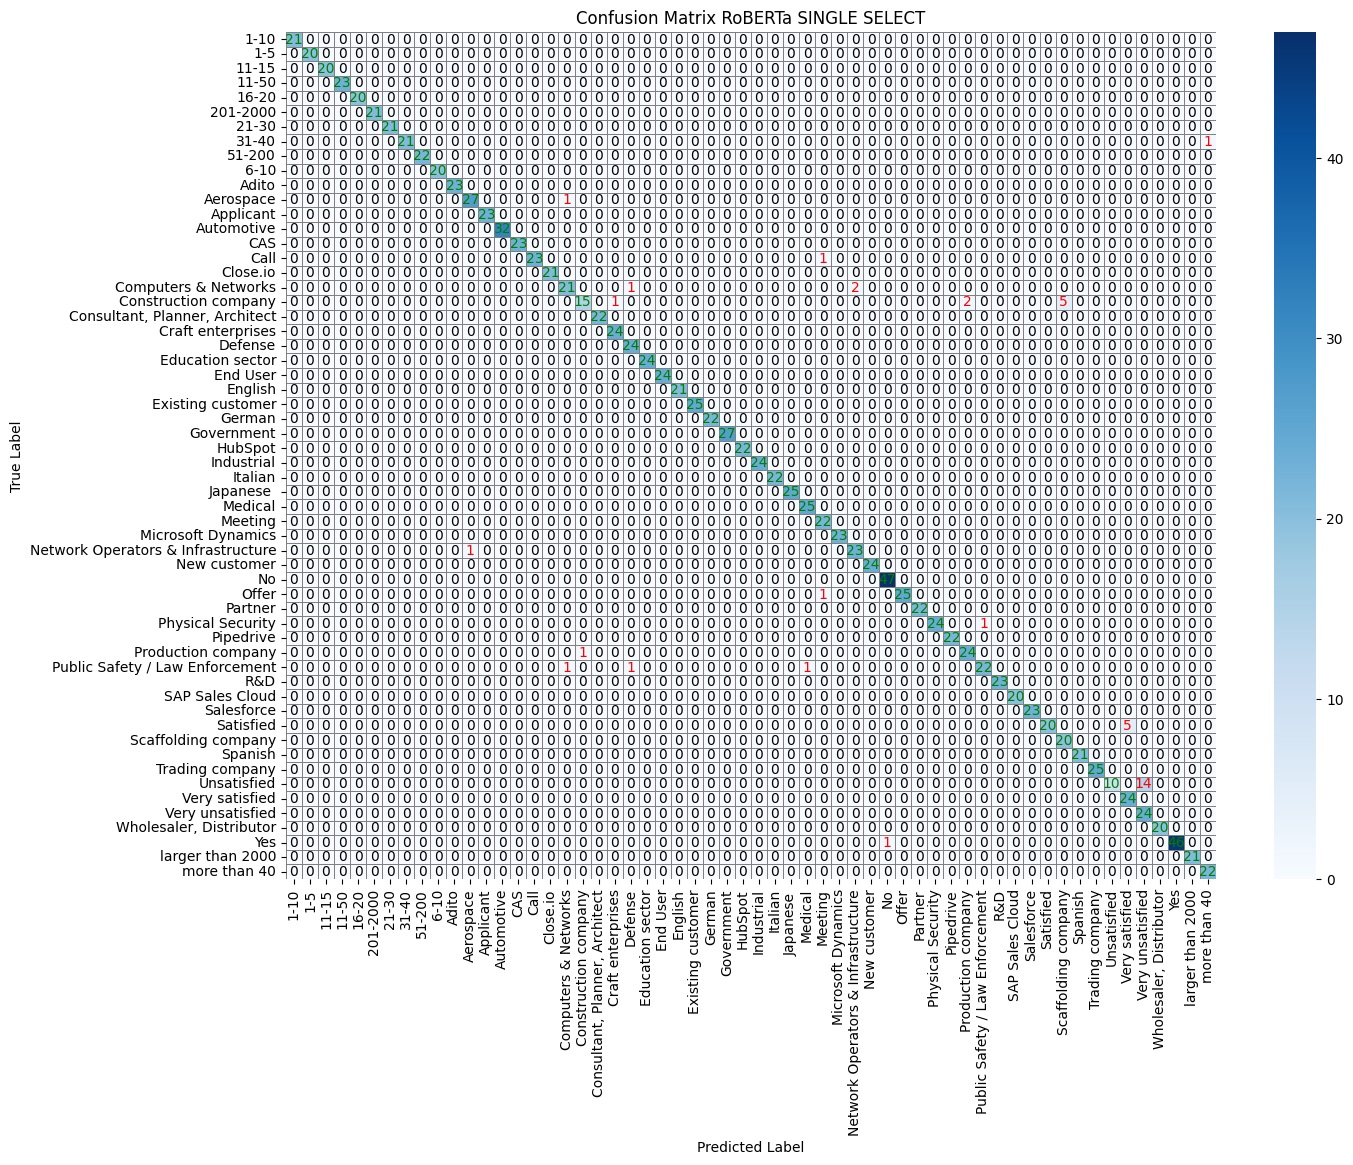

In [ ]:
plot_confusion_matrix(y_true_roberta_single_select, y_pred_roberta_single_select, model_name_roberta, label_mapping_single_select)

### Distilbert

#### 1. Tokenization

In [ ]:
model_name_distilbert = "distilbert-base-uncased"
tokenizer_distilbert_single_select = AutoTokenizer.from_pretrained(model_name_distilbert)

def tokenize_function_distilbert_single_select(examples):
    text_inputs = [q + " " + a for q, a in zip(examples["question"], examples["answer_text"])]
    return tokenizer_distilbert_single_select(text_inputs, truncation=True, padding="max_length", max_length=36)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenized_dataset_distilbert_single_select = dataset_single_select.map(tokenize_function_distilbert_single_select, batched=True)

Map:   0%|          | 0/5544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1386 [00:00<?, ? examples/s]

#### 2. Training

In [ ]:
model_single_select_distilbert = AutoModelForSequenceClassification.from_pretrained(model_name_distilbert, num_labels=len(label_encoder_single_select.classes_))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args_distilbert_single_select = TrainingArguments(
    output_dir="./distilbert_classification_single_select",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    learning_rate=1.5e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs/distilbert_classification_single_select",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    logging_steps=50
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience = 1,
    early_stopping_threshold = 0.000
)

In [ ]:
trainer_disitlibert_single_select = Trainer(
    model=model_single_select_distilbert,
    args=training_args_distilbert_single_select,
    train_dataset=tokenized_dataset_distilbert_single_select["train"],
    eval_dataset=tokenized_dataset_distilbert_single_select["test"],
    compute_metrics=compute_metrics_single_select,
    callbacks = [early_stopping]
)

In [ ]:
trainer_disitlibert_single_select.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.451600,1.040657,0.923521,0.914831,0.919796,0.923521
2,0.278000,0.175173,0.958153,0.953812,0.967927,0.958153
3,0.104100,0.102804,0.972583,0.972284,0.976304,0.972583
4,0.052800,0.130587,0.969697,0.969333,0.974134,0.969697


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=2772, training_loss=0.8100184676752118, metrics={'train_runtime': 232.232, 'train_samples_per_second': 477.454, 'train_steps_per_second': 59.682, 'total_flos': 206756068603392.0, 'train_loss': 0.8100184676752118, 'epoch': 4.0})

In [ ]:
trainer_disitlibert_single_select.save_model("drive/MyDrive/CapStone_models/distilbert_classification_single_select2")
tokenizer_distilbert_single_select.save_pretrained("drive/MyDrive/CapStone_models/distilbert_classification_single_select2")

('drive/MyDrive/CapStone_models/distilbert_classification_single_select2/tokenizer_config.json',
 'drive/MyDrive/CapStone_models/distilbert_classification_single_select2/special_tokens_map.json',
 'drive/MyDrive/CapStone_models/distilbert_classification_single_select2/vocab.txt',
 'drive/MyDrive/CapStone_models/distilbert_classification_single_select2/added_tokens.json',
 'drive/MyDrive/CapStone_models/distilbert_classification_single_select2/tokenizer.json')

#### 3. Evaluation

In [ ]:
metrics_distilbert_single_select = pd.DataFrame(trainer_disitlibert_single_select.state.log_history)

metrics_csv_path = "drive/MyDrive/CapStone_models/training_metrics_distilbert_single_select.csv"
metrics_distilbert_single_select.to_csv(metrics_csv_path, index=False)

print(f"Training metrics saved to {metrics_csv_path}")

Training metrics saved to drive/MyDrive/CapStone_models/training_metrics_distilbert_single_select.csv


In [ ]:
predictions_distilbert_single_select = trainer_disitlibert_single_select.predict(tokenized_dataset_distilbert_single_select["test"])

y_pred_distilbert_single_select = np.argmax(predictions_distilbert_single_select.predictions, axis=1)
y_true_distilbert_single_select = predictions_distilbert_single_select.label_ids

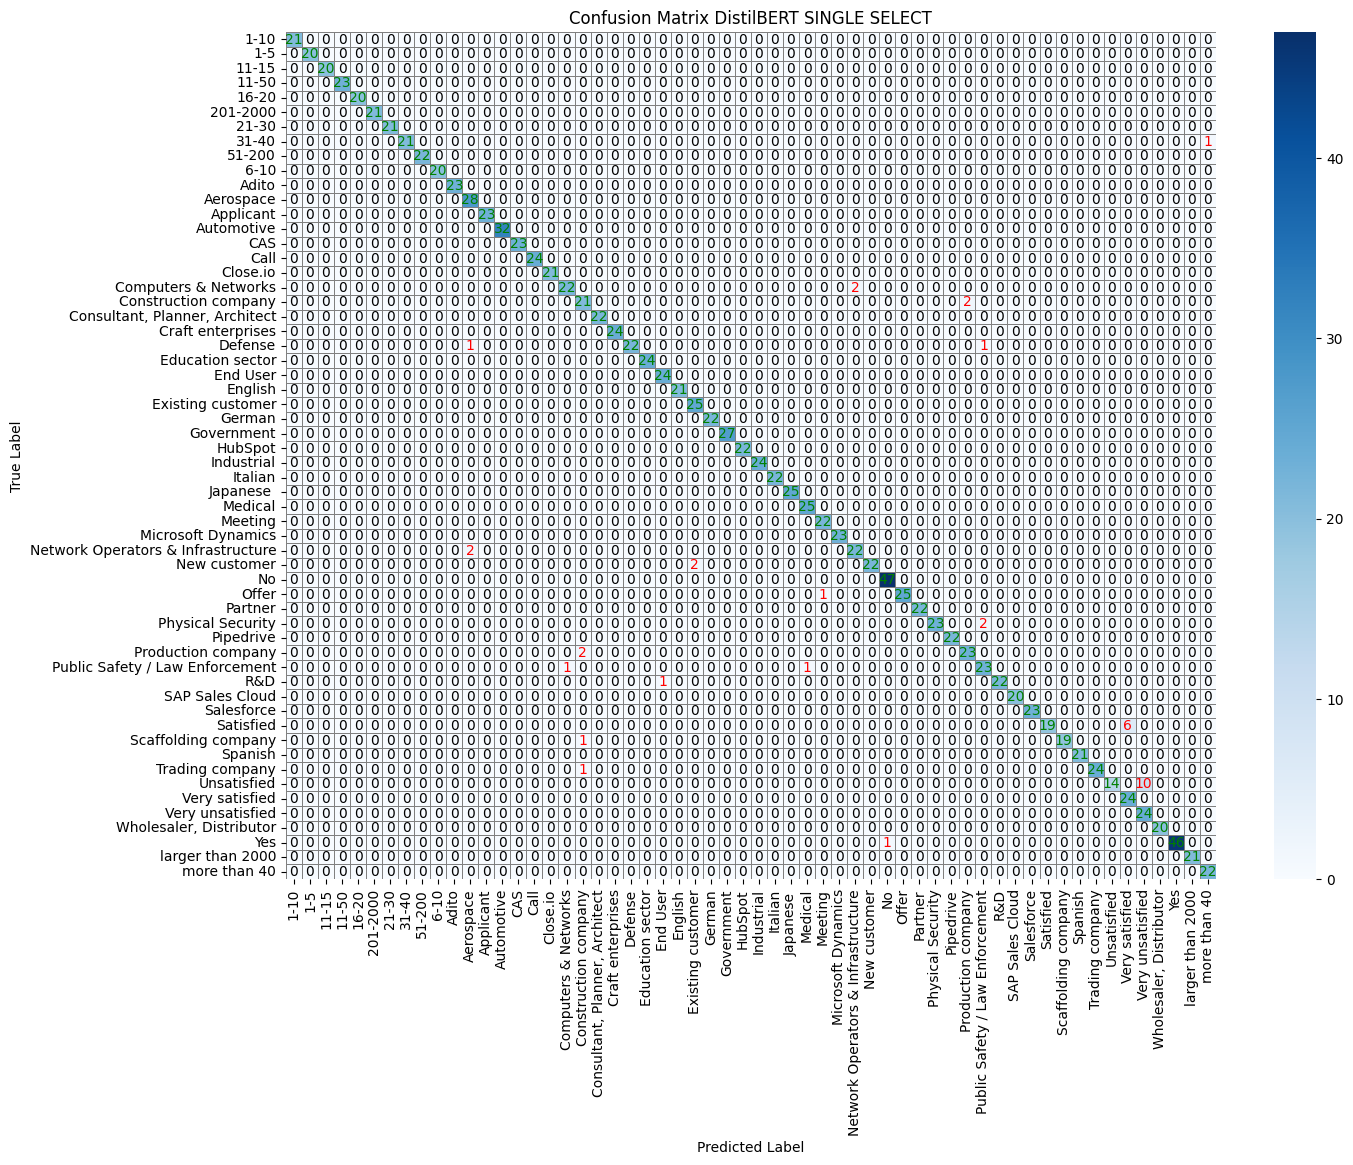

In [ ]:
plot_confusion_matrix(y_true_distilbert_single_select, y_pred_distilbert_single_select, model_name_distilbert, label_mapping_single_select)

In [ ]:
print("Classification Report:")
print(classification_report(y_true_distilbert_single_select, y_pred_distilbert_single_select, target_names=label_mapping_single_select.values()))

Classification Report:
                                    precision    recall  f1-score   support

                              1-10       1.00      1.00      1.00        21
                               1-5       1.00      1.00      1.00        20
                             11-15       1.00      1.00      1.00        20
                             11-50       1.00      1.00      1.00        23
                             16-20       1.00      1.00      1.00        20
                          201-2000       1.00      1.00      1.00        21
                             21-30       1.00      1.00      1.00        21
                             31-40       1.00      0.95      0.98        22
                            51-200       1.00      1.00      1.00        22
                              6-10       1.00      1.00      1.00        20
                             Adito       1.00      1.00      1.00        23
                         Aerospace       0.90      1.00      0.9

In [ ]:
#predictions_distilbert_single_select

### Tiny Llama

#### 1. Tokenization

In [ ]:
model_name_llama = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Tokenizer and Modell with LoRA (Low-Rank Adaptation)
tokenizer_llama = AutoTokenizer.from_pretrained(model_name_llama)
model_llama = AutoModelForSequenceClassification.from_pretrained(model_name_llama, num_labels=num_labels_single_select, device_map="auto")

# define Padding-Token (no default pad_token in LLaMa)
tokenizer_llama.pad_token = tokenizer_llama.eos_token
model_llama.config.pad_token_id = tokenizer_llama.eos_token_id


lora_config = LoraConfig(
    r=8, lora_alpha=32, target_modules=["q_proj", "v_proj"],  # target module for LoRA
    lora_dropout=0.05, bias="none", task_type="SEQ_CLS"
)

model_llama = get_peft_model(model_llama, lora_config)
model_llama.print_trainable_parameters()

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,245,184 || all params: 1,035,876,352 || trainable%: 0.1202


In [ ]:
def tokenize_data_llama(example):
    return tokenizer_llama(example["answer_text"], padding="max_length", truncation=True, max_length=256)

In [ ]:
tokenized_dataset_llama = dataset_single_select.map(tokenize_data_llama, batched=True)

Map:   0%|          | 0/5544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1386 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset_llama

DatasetDict({
    train: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5544
    })
    test: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1386
    })
})

In [ ]:
tokenized_dataset_llama.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
tokenized_dataset_llama

DatasetDict({
    train: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5544
    })
    test: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1386
    })
})

#### 2. Training

In [ ]:
training_args_llama = TrainingArguments(
    output_dir="/llama_classification_single_select",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer_llama = Trainer(
    model=model_llama,
    args=training_args_llama,
    train_dataset=tokenized_dataset_llama["train"],
    eval_dataset=tokenized_dataset_llama["test"],
    compute_metrics=compute_metrics_single_select
)

In [ ]:
trainer_llama.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.112500,0.086652,0.972583,0.972492,0.976042,0.972583
2,0.063500,0.061353,0.981241,0.981272,0.982405,0.981241
3,0.033800,0.052921,0.985570,0.985574,0.986626,0.985570
4,0.002800,0.057085,0.985570,0.985524,0.986179,0.985570


TrainOutput(global_step=11088, training_loss=0.21014529787552305, metrics={'train_runtime': 7010.2755, 'train_samples_per_second': 3.163, 'train_steps_per_second': 1.582, 'total_flos': 3.305205910418227e+16, 'train_loss': 0.21014529787552305, 'epoch': 4.0})

In [ ]:
trainer_llama.save_model("drive/MyDrive/CapStone_models/llama")
tokenizer_llama.save_pretrained("drive/MyDrive/CapStone_models/llama")

('drive/MyDrive/CapStone_models/llama/tokenizer_config.json',
 'drive/MyDrive/CapStone_models/llama/special_tokens_map.json',
 'drive/MyDrive/CapStone_models/llama/tokenizer.model',
 'drive/MyDrive/CapStone_models/llama/added_tokens.json',
 'drive/MyDrive/CapStone_models/llama/tokenizer.json')

#### 3. Evaluation

In [ ]:
metrics_llama = pd.DataFrame(trainer_llama.state.log_history)

metrics_csv_path = "drive/MyDrive/CapStone_models/training_metrics_llama.csv"
metrics_llama.to_csv(metrics_csv_path, index=False)

print(f"Training metrics saved to {metrics_csv_path}")

Training metrics saved to drive/MyDrive/CapStone_models/training_metrics_llama.csv


In [ ]:
# Evaluate the model on the test set
predictions_llama = trainer_llama.predict(tokenized_dataset_llama["test"])

# Extract predictions & true labels
y_pred_llama = np.argmax(predictions_llama.predictions, axis=1)  # Get predicted class labels
y_true_llama = predictions_llama.label_ids  # True labels

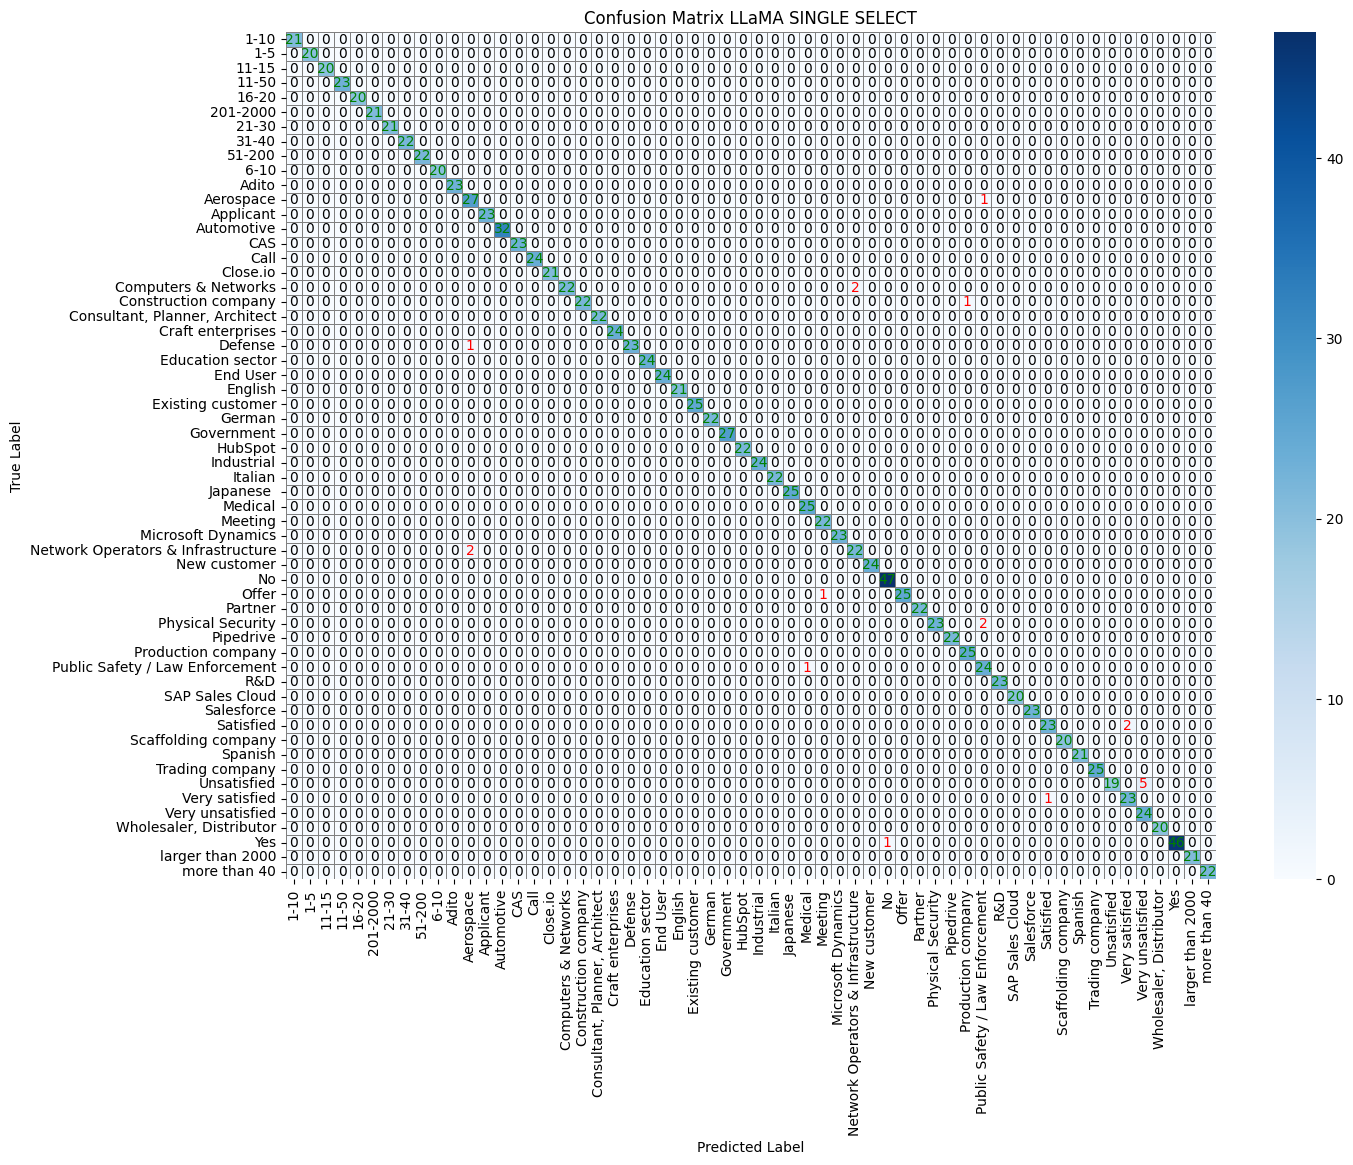

In [ ]:
plot_confusion_matrix(y_true_llama, y_pred_llama, model_name_llama, label_mapping_single_select)

In [ ]:
print("Classification Report:")
print(classification_report(y_true_llama, y_pred_llama, target_names=label_mapping_single_select.values()))

Classification Report:
                                    precision    recall  f1-score   support

                              1-10       1.00      1.00      1.00        21
                               1-5       1.00      1.00      1.00        20
                             11-15       1.00      1.00      1.00        20
                             11-50       1.00      1.00      1.00        23
                             16-20       1.00      1.00      1.00        20
                          201-2000       1.00      1.00      1.00        21
                             21-30       1.00      1.00      1.00        21
                             31-40       1.00      1.00      1.00        22
                            51-200       1.00      1.00      1.00        22
                              6-10       1.00      1.00      1.00        20
                             Adito       1.00      1.00      1.00        23
                         Aerospace       0.90      0.96      0.9

## Multi-Select Questions


Please upload the 'final_multi_question_data.json' file to the colab runtime before running the following code

### Preporcessing

Step 1: Load Data

In [ ]:
with open('final_multi_question_data.json', 'r') as file:
    multi_select_model_data = json.load(file)

Step 2: Encode labels

In [ ]:
# Reformat data -> binary vectors MultiLabelBinarizer
# Converting labels in Float32
def convert_to_multi_select_format(data, mlb):
    formatted_data = []

    for example in data:
        question = example["question"]
        answers = example["answers"]

        for answer in answers:
            text = answer.get("answer_text", "")
            labels = answer.get("answer_label", "").split(",")

            labels = [label.strip() for label in labels]
            #print(labels)

            if labels:  # Falls Labels vorhanden sind
                label_vector = mlb.transform([labels])[0]  # binary vectors
                label_vector = label_vector.astype(float)  # float convert

                formatted_data.append({
                    "question": question,
                    "text": text,
                    "labels": label_vector
                })

    return formatted_data

In [ ]:
all_labels_multi_select = set()
for example in multi_select_model_data:
    for answer in example["answers"]:
        labels = answer.get("answer_label", "").split(",")
        labels = [label.strip() for label in labels]
        all_labels_multi_select.update(labels)

#all_labels_multi_select

In [ ]:
# initializing MultiLabelBinarizer
multi_label_binarizer = MultiLabelBinarizer(classes=sorted(list(all_labels_multi_select)))
multi_label_binarizer.fit([list(all_labels_multi_select)])

MultiLabelBinarizer(classes=["'Angelina Haug'", "'Domiki Stein'",
                             "'Erik Schneider'", "'Jens Roschmann'",
                             "'Jessica Hanke'", "'Joachim Wagner'",
                             "'Johannes Wagner'", "'Marisa Peng'",
                             "'Oliver Eibel'", "'Sandro Kalter'",
                             "'Sean Kennin'", "'Stephan Maier'",
                             "'Tim Persson'", '1 week', '100', '2 weeks', '200',
                             '234', '256', '3 weeks', '300', 'AKW100', 'AX100',
                             'Automotive radar target simulation',
                             'BusinessCards', 'Capture trade fair contacts',
                             'Clean up CRM', 'Competitor', 'Data Cleansing',
                             'DataEnrichment', ...])

In [ ]:
# Saving label mapping
label_mapping_multi_select = {idx: label for idx, label in enumerate(multi_label_binarizer.classes_)}
inverse_label_mapping_multi_select = {label: idx for idx, label in enumerate(multi_label_binarizer.classes_)}

label_mapping_multi_select_path = "drive/MyDrive/CapStone_models/label_mapping_multi_wQ.pkl"

with open(label_mapping_multi_select_path, "wb") as file:
    pickle.dump(label_mapping_multi_select, file)

print("Label-Mapping erfolgreich gespeichert.")

Label-Mapping erfolgreich gespeichert.


In [ ]:
formatted_multi_dataset = convert_to_multi_select_format(multi_select_model_data, multi_label_binarizer)

Step 3: Check formated data

In [ ]:
print(f"Examples: {len(formatted_multi_dataset)}")
if formatted_multi_dataset:
    print(f"Example: {formatted_multi_dataset[0]}")
print(f"Possible Labels: {multi_label_binarizer.classes_}")

Examples: 745
Example: {'question': 'What are your product interests?', 'text': "I'm interested in improving data quality and generating business cards.", 'labels': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])}
Possible Labels: ["'Angelina Haug'" "'Domiki Stein'" "'Erik Schneider'" "'Jens Roschmann'"
 "'Jessica Hanke'" "'Joachim Wagner'" "'Johannes Wagner'" "'Marisa Peng'"
 "'Oliver Eibel'" "'Sandro Kalter'" "'Sean Kennin'" "'Stephan Maier'"
 "'Tim Persson'" '1 week' '100' '2 weeks' '200' '234' '256' '3 weeks'
 '300' 'AKW100' 'AX100' 'Automotive radar target simulation'
 'BusinessCards' 'Capture trade fair contacts' 'Clean up CRM' 'Competitor'
 'Data Cleansing' 'DataEnrichment' 'DataQuality'
 'Display port debugging and compliance' 'Double-Pulse Testing' 'Email'
 'Existing customer' 'Extract d

Step 4: Create Train Test Split

In [ ]:
train_data_multi_formatted, eval_data_multi_formatted = train_test_split(formatted_multi_dataset, test_size=0.2, random_state=1)

In [ ]:
#train_data_multi_formatted

Step 5: Create Huggingface Dataset

In [ ]:
dataset_multi_select = DatasetDict({
    "train": Dataset.from_list(train_data_multi_formatted),
    "test": Dataset.from_list(eval_data_multi_formatted)
})

In [ ]:
#len(dataset_multi_select["train"])

In [ ]:
print(f"Anzahl der Trainingsdaten: {len(dataset_multi_select['train'])}")
print(f"Anzahl der Evaluationsdaten: {len(dataset_multi_select['test'])}")

Anzahl der Trainingsdaten: 596
Anzahl der Evaluationsdaten: 149


In [ ]:
# Metrics for Multi-Label Classification
def compute_metrics_multi_select(pred):
    labels = pred.label_ids  # Wahre Labels
    preds = torch.sigmoid(torch.tensor(pred.predictions)) > 0.5  # Probabilities -> binary values

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds.numpy(), average="weighted"
    )
    acc = (preds.numpy() == labels).all(axis=1).mean()
    hamming = hamming_loss(labels, preds.numpy())
    jaccard = jaccard_score(labels, preds.numpy(), average="samples")
    mcc = matthews_corrcoef(labels.flatten(), preds.numpy().flatten())

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "hamming_loss": hamming,
        "jaccard_similarity": jaccard,
        "mcc": mcc
    }

In [ ]:
# Loss-function for multi-label classification
def custom_loss(predictions, labels):
    return F.binary_cross_entropy_with_logits(predictions, labels)

In [ ]:
# Custom Trainer with adjusted loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")  # remove labels from inputs
        outputs = model(**inputs)      # predictions
        logits = outputs.logits        # extract logits
        loss = custom_loss(logits, labels)  # BCEWithLogitsLoss calculation
        return (loss, outputs) if return_outputs else loss

### Roberta

In [ ]:
model_name_roberta = 'deepset/roberta-base-squad2'

tokenizer_roberta_multilabel = AutoTokenizer.from_pretrained(model_name_roberta)

def preprocess_function_multi(examples):
    return tokenizer_roberta_multilabel(
        examples["question"],
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [ ]:
tokenized_dataset_multi_select_roberta = dataset_multi_select.map(preprocess_function_multi, batched=True)

Map:   0%|          | 0/596 [00:00<?, ? examples/s]

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

In [ ]:
# Set to PyTorch-compatible format
tokenized_dataset_multi_select_roberta.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
print(tokenized_dataset_multi_select_roberta["train"][0])
print(tokenized_dataset_multi_select_roberta["train"][0]["labels"])  # should be Float-Tensor
print(tokenized_dataset_multi_select_roberta["train"][0]["labels"].dtype)  # expected: torch.float32

{'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 'input_ids': tensor([    0,  2264,   936,    32,    47,   667,     7,  6136,   116,     2,
            2,   100,   437,   745,    10,  3944,     7, 14146,  3679,     5,
          739,   346,     9,   265,  3591,  4786,    23,   721,  2105,    29,
            4,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1, 

In [ ]:
model_multi_select_roberta = AutoModelForSequenceClassification.from_pretrained(
    model_name_roberta,
    num_labels=len(multi_label_binarizer.classes_),  # labelcount
    problem_type="multi_label_classification"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args_roberta_multi_select = TrainingArguments(
    output_dir="./roberta_classification_multi_select",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=30,
    learning_rate=7e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs/roberta_classification_multi_select",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    logging_steps=2,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define the EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3  # Stop after 3 evaluations with no improvement
)

In [ ]:
trainer_roberta_multi_select = CustomTrainer(
    model=model_multi_select_roberta,
    args=training_args_roberta_multi_select,
    train_dataset=tokenized_dataset_multi_select_roberta["train"],
    eval_dataset=tokenized_dataset_multi_select_roberta["test"],
    compute_metrics=compute_metrics_multi_select,
    callbacks=[early_stopping_callback],
)

In [ ]:
trainer_roberta_multi_select.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hamming Loss,Jaccard Similarity,Mcc,Runtime,Samples Per Second,Steps Per Second
1,0.139200,0.146601,0.000000,0.000000,0.000000,0.000000,0.037862,0.000000,0.000000,1.091600,136.503000,34.813000
2,0.093200,0.105196,0.067114,0.116710,0.104001,0.137124,0.035077,0.129083,0.295906,1.036300,143.788000,36.671000
3,0.090700,0.085015,0.107383,0.234685,0.256796,0.254181,0.031658,0.221141,0.421613,1.121700,132.837000,33.878000
4,0.083400,0.076250,0.127517,0.236654,0.268159,0.240803,0.031784,0.208389,0.413906,1.101700,135.246000,34.492000
5,0.066000,0.072287,0.154362,0.359803,0.369000,0.387960,0.028745,0.301454,0.517719,1.157300,128.749000,32.835000
6,0.067000,0.066155,0.161074,0.376826,0.411510,0.397993,0.028998,0.312416,0.517905,1.131100,131.734000,33.597000
7,0.071500,0.066405,0.167785,0.377824,0.427340,0.397993,0.029505,0.305928,0.511291,1.154300,129.081000,32.920000
8,0.058700,0.062120,0.214765,0.500293,0.516793,0.521739,0.024820,0.411745,0.612087,1.117900,133.280000,33.991000
9,0.101500,0.058748,0.161074,0.439348,0.504856,0.421405,0.025833,0.332774,0.570609,1.182300,126.031000,32.142000
10,0.051700,0.057982,0.214765,0.468044,0.512239,0.474916,0.026212,0.400671,0.580371,1.109300,134.314000,34.255000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

TrainOutput(global_step=4470, training_loss=0.05006780215691133, metrics={'train_runtime': 1154.9537, 'train_samples_per_second': 15.481, 'train_steps_per_second': 3.87, 'total_flos': 1176644966492160.0, 'train_loss': 0.05006780215691133, 'epoch': 30.0})

In [ ]:
trainer_roberta_multi_select.save_model("drive/MyDrive/CapStone_models/roberta_classification_multi_select")
tokenizer_roberta_multilabel.save_pretrained("drive/MyDrive/CapStone_models/roberta_classification_multi_select")

('drive/MyDrive/CapStone_models/roberta_classification_multi_select/tokenizer_config.json',
 'drive/MyDrive/CapStone_models/roberta_classification_multi_select/special_tokens_map.json',
 'drive/MyDrive/CapStone_models/roberta_classification_multi_select/vocab.json',
 'drive/MyDrive/CapStone_models/roberta_classification_multi_select/merges.txt',
 'drive/MyDrive/CapStone_models/roberta_classification_multi_select/added_tokens.json',
 'drive/MyDrive/CapStone_models/roberta_classification_multi_select/tokenizer.json')

In [ ]:
metrics_roberta_multi_select = pd.DataFrame(trainer_roberta_multi_select.state.log_history)

metrics_csv_path = "drive/MyDrive/CapStone_models/training_metrics_roberta_multi_select.csv"
metrics_roberta_multi_select.to_csv(metrics_csv_path, index=False)

print(f"Training metrics saved to {metrics_csv_path}")

Training metrics saved to drive/MyDrive/CapStone_models/training_metrics_roberta_multi_select.csv


### Distilbert

In [ ]:
model_name_distilbert = "distilbert-base-uncased"
tokenizer_distilbert_multi_select = AutoTokenizer.from_pretrained(model_name_distilbert)

def preprocess_function_multi_distilbert(examples):
    return tokenizer_distilbert_multi_select(
        examples["question"],
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [ ]:
tokenized_dataset_multi_select_distilbert = dataset_multi_select.map(preprocess_function_multi_distilbert, batched=True)

tokenized_dataset_multi_select_distilbert.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print(tokenized_dataset_multi_select_distilbert["train"][0])
print(tokenized_dataset_multi_select_distilbert["train"][0]["labels"])
print(tokenized_dataset_multi_select_distilbert["train"][0]["labels"].dtype)

Map:   0%|          | 0/596 [00:00<?, ? examples/s]

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

{'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 'input_ids': tensor([  101,  2054,  3291,  2024,  2017,  2667,  2000,  9611,  1029,   102,
         1045,  1005,  1049,  2311,  1037,  6994,  2000, 18228,  5047,  1996,
         2312,  2193,  1997,  2449,  5329,  5067,  2012,  3119, 21947,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 

In [ ]:
model_multi_select_distilbert = DistilBertForSequenceClassification.from_pretrained(
    model_name_distilbert,
    num_labels=len(multi_label_binarizer.classes_),
    problem_type="multi_label_classification"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args_multi_select_distilbert = TrainingArguments(
    output_dir="./distilbert_classification_multi_select",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=30,
    learning_rate=5e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs/distilbert_classification_multi_select",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    logging_steps=2,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Early Stopping Callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # stop at 1 epoch worse
    early_stopping_threshold=0.000  #  min same
)

In [ ]:
trainer_multi_select_distilbert = CustomTrainer(
    model=model_multi_select_distilbert,
    args=training_args_multi_select_distilbert,
    train_dataset=tokenized_dataset_multi_select_distilbert["train"],
    eval_dataset=tokenized_dataset_multi_select_distilbert["test"],
    compute_metrics=compute_metrics_multi_select,
    callbacks=[early_stopping]
)


In [ ]:
trainer_multi_select_distilbert.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hamming Loss,Jaccard Similarity,Mcc,Runtime,Samples Per Second,Steps Per Second
1,0.133600,0.142971,0.000000,0.000000,0.000000,0.000000,0.037862,0.000000,0.000000,1.144700,130.163000,33.196000
2,0.084600,0.095580,0.020134,0.111101,0.124518,0.107023,0.034443,0.071812,0.297285,0.564100,264.158000,67.369000
3,0.076500,0.072141,0.167785,0.342173,0.430739,0.321070,0.028618,0.278316,0.498269,0.596100,249.979000,63.753000
4,0.065600,0.057353,0.248322,0.468722,0.539206,0.451505,0.024566,0.377852,0.597235,0.577200,258.163000,65.840000
5,0.042100,0.046828,0.395973,0.661642,0.787505,0.622074,0.017982,0.575056,0.725100,0.586300,254.145000,64.816000
6,0.032800,0.040409,0.483221,0.769182,0.786960,0.789298,0.014436,0.699329,0.798148,0.597900,249.210000,63.557000
7,0.027400,0.033554,0.604027,0.817644,0.860367,0.802676,0.010637,0.785123,0.847226,0.601200,247.823000,63.203000
8,0.022000,0.028655,0.711409,0.899390,0.914661,0.906355,0.007091,0.852237,0.902669,0.570500,261.155000,66.603000
9,0.030200,0.025376,0.691275,0.853895,0.880369,0.846154,0.008864,0.826398,0.874567,0.593700,250.969000,64.006000
10,0.014700,0.022184,0.758389,0.906225,0.948690,0.889632,0.006332,0.880984,0.911176,0.573500,259.793000,66.256000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

TrainOutput(global_step=4023, training_loss=0.030912060647894538, metrics={'train_runtime': 421.0788, 'train_samples_per_second': 42.462, 'train_steps_per_second': 10.616, 'total_flos': 533401038922752.0, 'train_loss': 0.030912060647894538, 'epoch': 27.0})

In [ ]:
trainer_multi_select_distilbert.save_model("drive/MyDrive/CapStone_models/distilbert_classification_multi_select")
tokenizer_distilbert_multi_select.save_pretrained("drive/MyDrive/CapStone_models/distilbert_classification_multi_select")

In [ ]:
metrics_distilbert_multi_select = pd.DataFrame(trainer_multi_select_distilbert.state.log_history)

metrics_csv_path = "drive/MyDrive/CapStone_models/training_metrics_distilbert_multi_select.csv"
metrics_distilbert_multi_select.to_csv(metrics_csv_path, index=False)

print(f"Training metrics saved to {metrics_csv_path}")

Training metrics saved to drive/MyDrive/CapStone_models/training_metrics_distilbert_multi_select.csv


# Evaluation

## Overview Result Values

In [5]:
# Predefined paths for single and multi models
single_models = {
    "distilbert_single": "/content/drive/MyDrive/CapStone_models/training_metrics_distilbert_single_select.csv",
    "roberta_single": "/content/drive/MyDrive/CapStone_models/training_metrics_roberta_single_select.csv",
    "lama_single": "/content/drive/MyDrive/CapStone_models/training_metrics_llama.csv"
}

multi_models = {
    "distilbert_multi": "/content/drive/MyDrive/CapStone_models/training_metrics_distilbert_multi_select.csv",
    "roberta_multi": "/content/drive/MyDrive/CapStone_models/training_metrics_roberta_multi_select.csv",
}

# function processing single and mutli model data
def process_metrics(csv_path, model_name, is_multi=False):
    try:

        metrics_df = pd.read_csv(csv_path)

        epoch_metrics = metrics_df[metrics_df['eval_loss'].notna()].copy()

        epoch_metrics['Training Loss'] = epoch_metrics.index.map(
            lambda idx: metrics_df.loc[idx - 1, 'loss'] if idx > 0 else None
        )

        # create summary for "over all" metrics
        summary_columns = ['epoch', 'Training Loss', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']

        # If multi, add additional metrics
        if is_multi:
            summary_columns.extend(['eval_hamming_loss', 'eval_jaccard_similarity', 'eval_mcc'])

        # Create summary dataframe
        summary_table = epoch_metrics[summary_columns].copy()

        # Rename columns for better readability
        summary_table.rename(columns={
            'eval_loss': 'Validation Loss',
            'eval_accuracy': 'Accuracy',
            'eval_f1': 'F1',
            'eval_precision': 'Precision',
            'eval_recall': 'Recall',
            'eval_hamming_loss': 'Hamming Loss',
            'eval_jaccard_similarity': 'Jaccard Similarity',
            'eval_mcc': 'Matthews Correlation Coefficient'
        }, inplace=True)

        # print summary values for model
        print(f"\nSummary Values for {model_name}:\n")
        print(summary_table)

        # Save summary table locally
        summary_csv_path = f"./summary_{model_name}.csv"
        summary_table.to_csv(summary_csv_path, index=False)
        print(f"Saved at {summary_csv_path}.\n")

    except Exception as e:
        print(f"Error {csv_path} for {model_name}: {e}")

# Process Single-Select Models
print("\nProcessing Single-Select Models\n")
for model_name, csv_path in single_models.items():
    process_metrics(csv_path, model_name, is_multi=False)

# Process Multi-Select Models (including extra metrics)
print("\nProcessing Multi-Select Models\n")
for model_name, csv_path in multi_models.items():
    process_metrics(csv_path, model_name, is_multi=True)


Processing Single-Select Models


Summary Values for distilbert_single:

    epoch  Training Loss  Validation Loss  Accuracy        F1  Precision  \
13    1.0         1.4516         1.040657  0.923521  0.914831   0.919796   
28    2.0         0.2780         0.175173  0.958153  0.953812   0.967927   
43    3.0         0.1041         0.102804  0.972583  0.972284   0.976304   
58    4.0         0.0528         0.130587  0.969697  0.969333   0.974134   

      Recall  
13  0.923521  
28  0.958153  
43  0.972583  
58  0.969697  
Saved at ./summary_distilbert_single.csv.


Summary Values for roberta_single:

     epoch  Training Loss  Validation Loss  Accuracy        F1  Precision  \
173    1.0         0.2892         0.146570  0.963925  0.958181   0.956397   
348    2.0         0.0155         0.144290  0.962482  0.960826   0.970443   
522    3.0         0.0176         0.123647  0.970418  0.969064   0.975490   
697    4.0         0.2976         0.131998  0.961039  0.955240   0.954589   

    

## Training Loss vs Validation Loss


Processing Single-Select Models



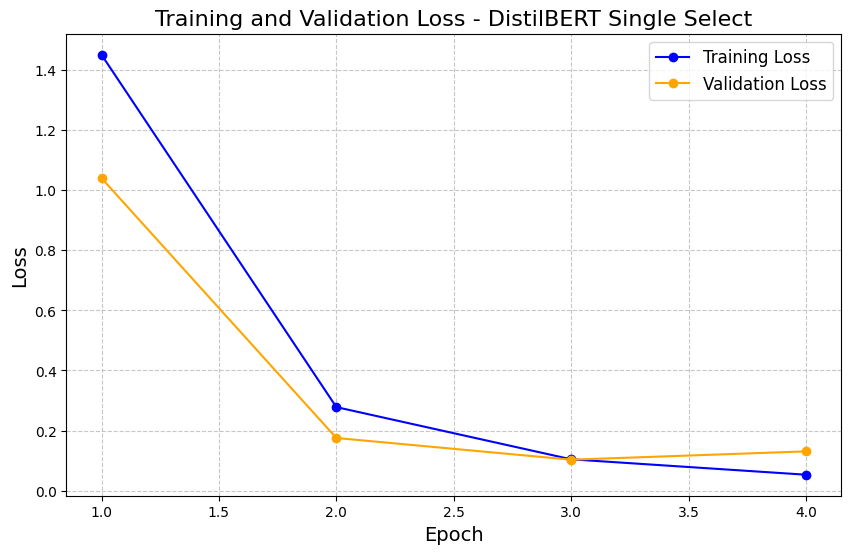

Plot for distilbert_single saved at ./distilbert_single_loss_plot.png.


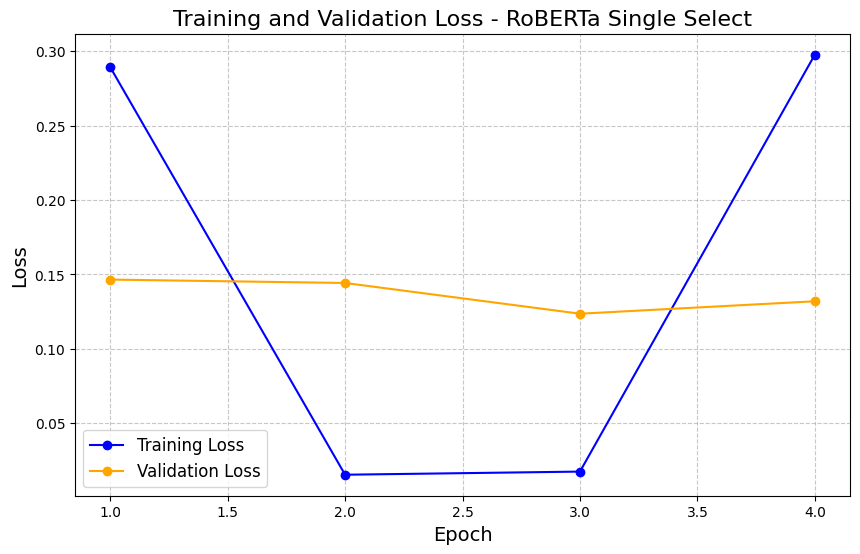

Plot for roberta_single saved at ./roberta_single_loss_plot.png.


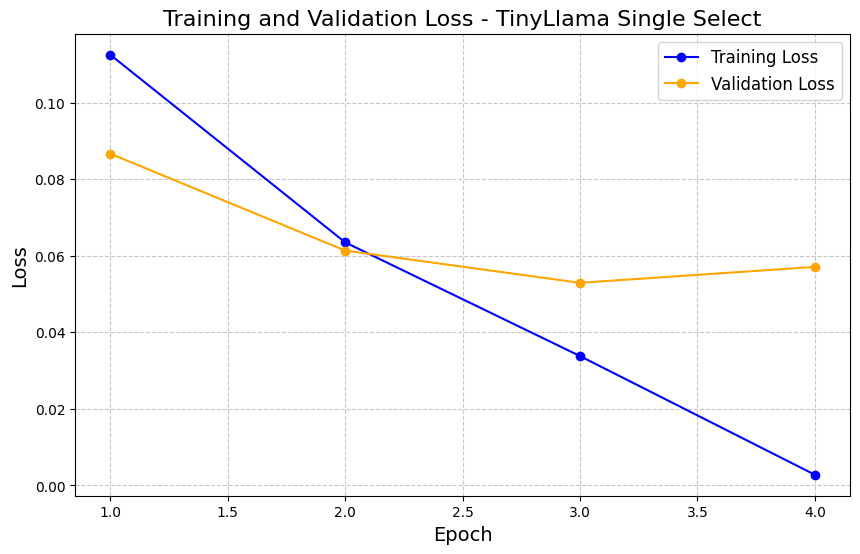

Plot for lama_single saved at ./lama_single_loss_plot.png.

Processing Multi-Select Models



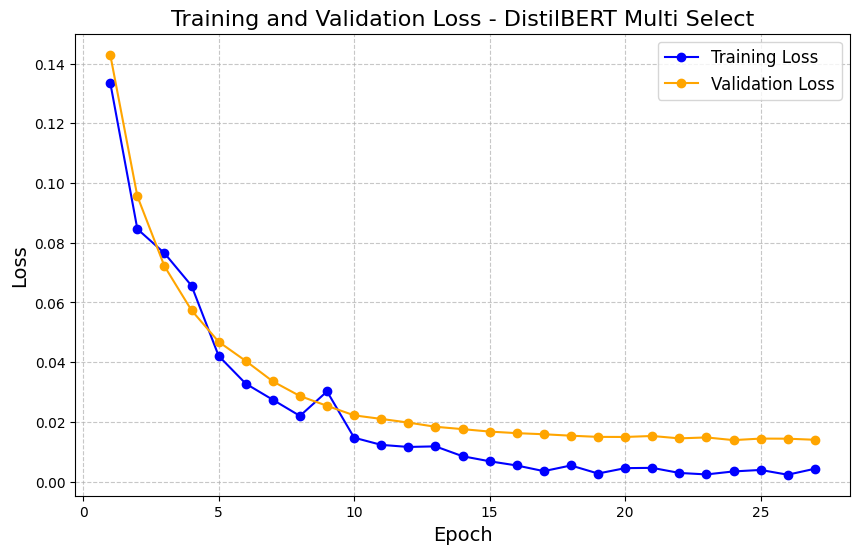

Plot for distilbert_multi saved at ./distilbert_multi_loss_plot.png.


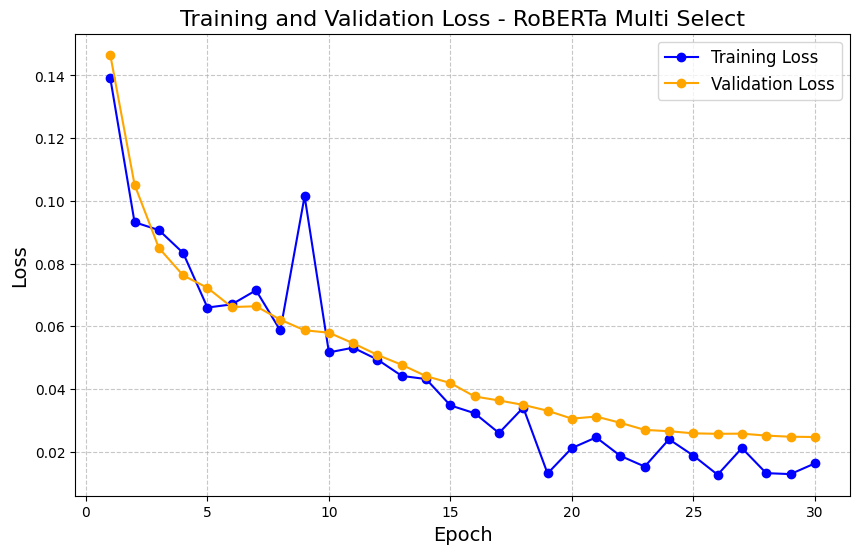

Plot for roberta_multi saved at ./roberta_multi_loss_plot.png.


In [10]:
# Predefined paths for single and multi models for new csv datasets
single_models = {
    "distilbert_single": "./summary_distilbert_single.csv",
    "roberta_single": "./summary_roberta_single.csv",
    "lama_single": "./summary_lama_single.csv"
}

multi_models = {
    "distilbert_multi": "./summary_distilbert_multi.csv",
    "roberta_multi": "./summary_roberta_multi.csv",
}

csv_paths = {
    "distilbert_single": "./summary_distilbert_single.csv",
    "roberta_single": "./summary_roberta_single.csv",
    "lama_single": "./summary_lama_single.csv",
    "distilbert_multi": "./summary_distilbert_multi.csv",
    "roberta_multi": "./summary_roberta_multi.csv",
}

def plot_losses(csv_path, model_name):
    try:
        # load data
        metrics_df = pd.read_csv(csv_path)

        print_name = "DistilBERT Single Select"

        if model_name == "roberta_single":
            print_name = "RoBERTa Single Select"
        elif model_name == "lama_single":
            print_name = "TinyLlama Single Select"
        elif model_name == "distilbert_multi":
            print_name = "DistilBERT Multi Select"
        elif model_name == "roberta_multi":
            print_name = "RoBERTa Multi Select"

        # create plot
        plt.figure(figsize=(10, 6))
        plt.plot(metrics_df['epoch'], metrics_df['Training Loss'], label='Training Loss', color='blue', marker='o')
        plt.plot(metrics_df['epoch'], metrics_df['Validation Loss'], label='Validation Loss', color='orange', marker='o')
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("Loss", fontsize=14)
        plt.title(f"Training and Validation Loss - {print_name}", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)

        # save plot
        save_path = f"./{model_name}_loss_plot.png"
        plt.savefig(save_path, bbox_inches="tight")
        plt.show()
        print(f"Plot for {model_name} saved at {save_path}.")
    except Exception as e:
        print(f"Error at {model_name}: {e}")

# Process Single-Select Models
print("\nProcessing Single-Select Models\n")
for model_name, csv_path in single_models.items():
    plot_losses(csv_path, model_name)

# Process Multi-Select Models (including extra metrics)
print("\nProcessing Multi-Select Models\n")
for model_name, csv_path in multi_models.items():
    plot_losses(csv_path, model_name)

## F1 Score Single vs Multi Models

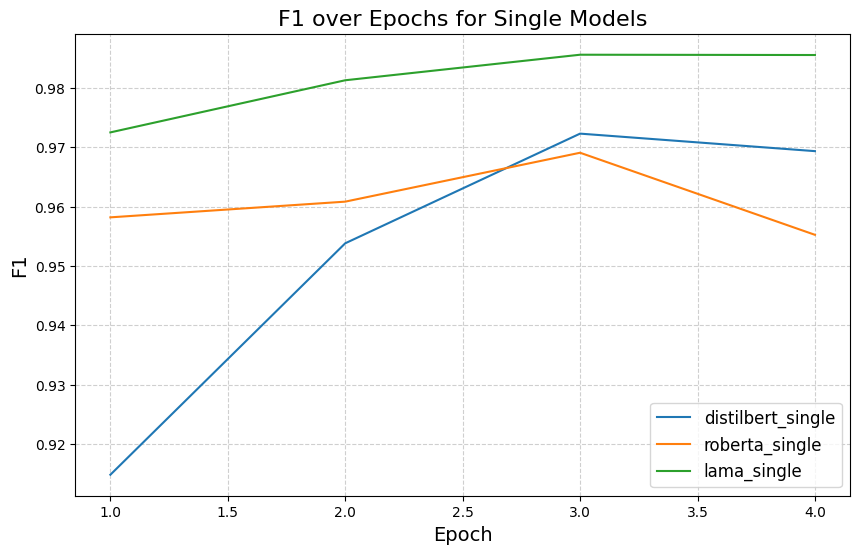

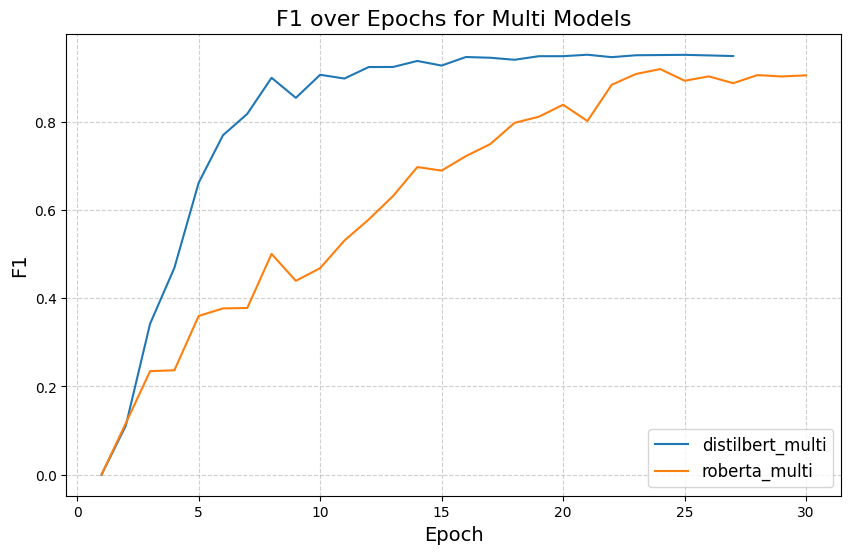

In [11]:
# Function to plot accuracy over epochs for given models
def plot_f1(models, title):
    plt.figure(figsize=(10, 6))
    for model_name, csv_path in models.items():
        try:
            # read file
            df = pd.read_csv(csv_path)

            # extract data
            epochs = df['epoch']
            accuracy = df['F1']

            # Plot accuracy
            plt.plot(epochs, accuracy, label=model_name)
        except Exception as e:
            print(f"Error reading {csv_path} for {model_name}: {e}")

    plt.title(title, fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("F1", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Plot for single models
plot_f1(single_models, "F1 over Epochs for Single Models")

# Plot for multi models
plot_f1(multi_models, "F1 over Epochs for Multi Models")

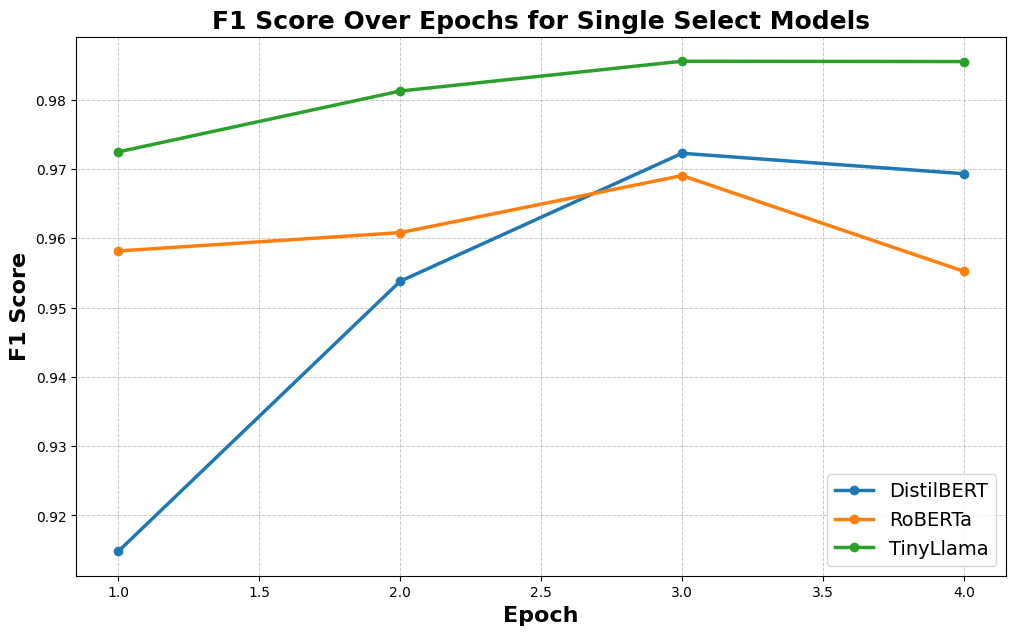

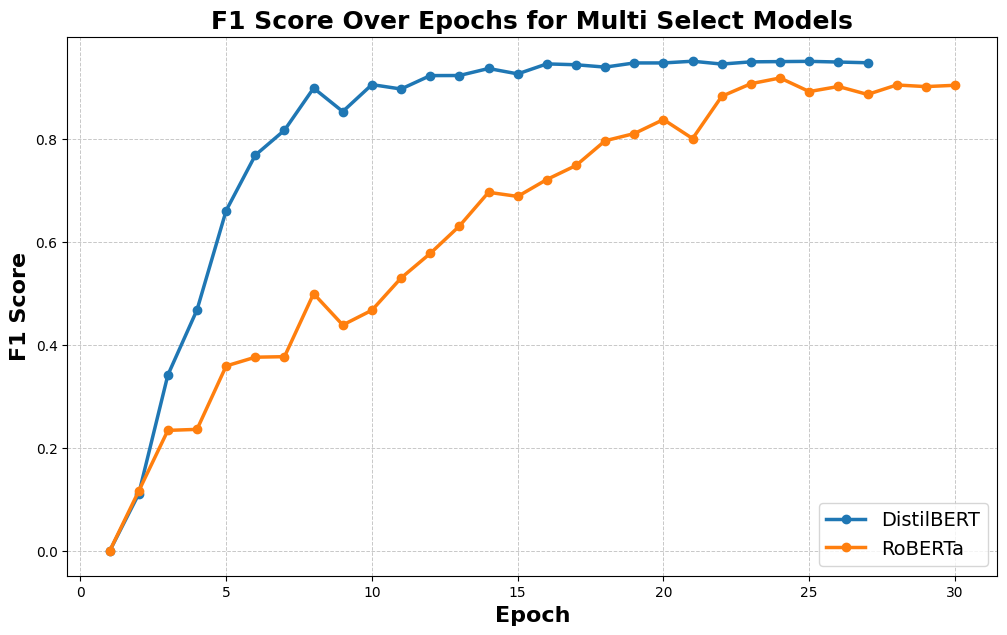

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_f1(models, title, mode="single"):
    plt.figure(figsize=(12, 7))

    # Mapping model names to legend labels
    legend_mapping = {
        "roberta_single": "RoBERTa",
        "lama_single": "TinyLlama",
        "distilbert_multi": "DistilBERT",
        "roberta_multi": "RoBERTa"
    }

    for model_name, csv_path in models.items():
        try:
            # Read file
            df = pd.read_csv(csv_path)

            # Extract data
            epochs = df['epoch']
            accuracy = df['F1']

            # Get legend name with fallback
            legend_name = legend_mapping.get(model_name, "DistilBERT")

            # Plot with enhancements
            plt.plot(epochs, accuracy, label=legend_name, linewidth=2.5, marker='o', markersize=6)

        except Exception as e:
            print(f"Error reading {csv_path} for {model_name}: {e}")

    # Title and labels
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel("Epoch", fontsize=16, fontweight='bold')
    plt.ylabel("F1 Score", fontsize=16, fontweight='bold')

    # Legend
    plt.legend(fontsize=14, loc='lower right')

    # Grid styling
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    # Save figure
    save_path = f"drive/MyDrive/CapStone_models/f1_{mode}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality save

    # Show the plot
    plt.show()

# Plot for single models
plot_f1(single_models, "F1 Score Over Epochs for Single Select Models")

# Plot for multi models
plot_f1(multi_models, "F1 Score Over Epochs for Multi Select Models", mode="multi")


## Overview Data each Model seperate

Processing distilbert_single...
   epoch  Training Loss  Validation Loss  Accuracy        F1  Precision  \
0    1.0         1.4516         1.040657  0.923521  0.914831   0.919796   
1    2.0         0.2780         0.175173  0.958153  0.953812   0.967927   
2    3.0         0.1041         0.102804  0.972583  0.972284   0.976304   
3    4.0         0.0528         0.130587  0.969697  0.969333   0.974134   

     Recall  
0  0.923521  
1  0.958153  
2  0.972583  
3  0.969697  


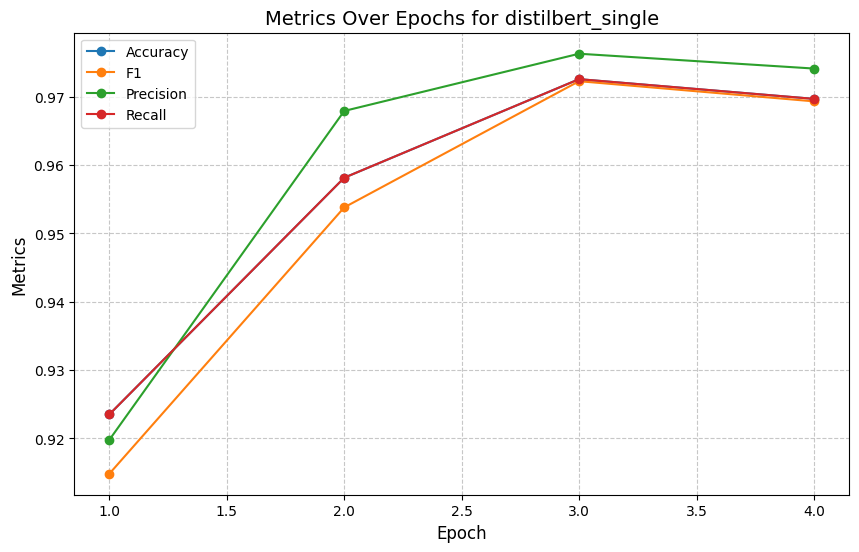

Plot saved at ./metrics_plot_distilbert_single.png
Processing roberta_single...
   epoch  Training Loss  Validation Loss  Accuracy        F1  Precision  \
0    1.0         0.2892         0.146570  0.963925  0.958181   0.956397   
1    2.0         0.0155         0.144290  0.962482  0.960826   0.970443   
2    3.0         0.0176         0.123647  0.970418  0.969064   0.975490   
3    4.0         0.2976         0.131998  0.961039  0.955240   0.954589   

     Recall  
0  0.963925  
1  0.962482  
2  0.970418  
3  0.961039  


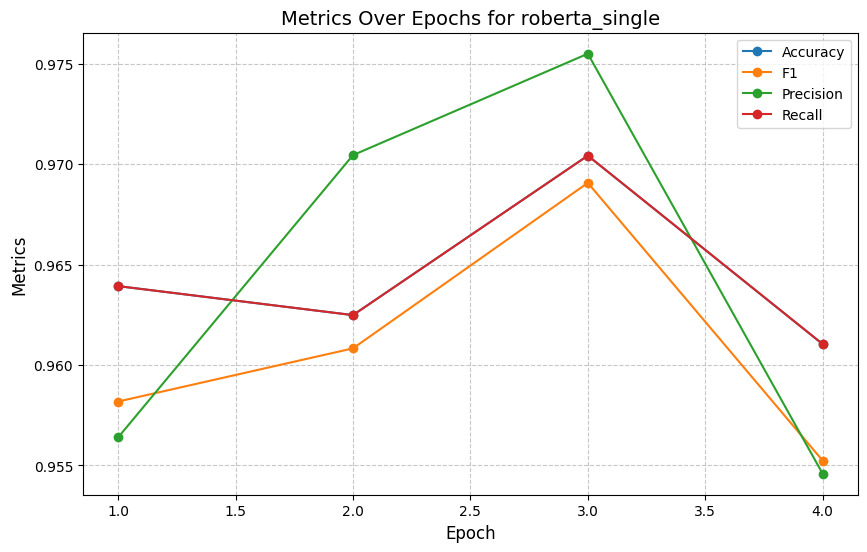

Plot saved at ./metrics_plot_roberta_single.png
Processing lama_single...
   epoch  Training Loss  Validation Loss  Accuracy        F1  Precision  \
0    1.0         0.1125         0.086652  0.972583  0.972492   0.976042   
1    2.0         0.0635         0.061353  0.981241  0.981272   0.982405   
2    3.0         0.0338         0.052921  0.985570  0.985574   0.986626   
3    4.0         0.0028         0.057085  0.985570  0.985524   0.986179   

     Recall  
0  0.972583  
1  0.981241  
2  0.985570  
3  0.985570  


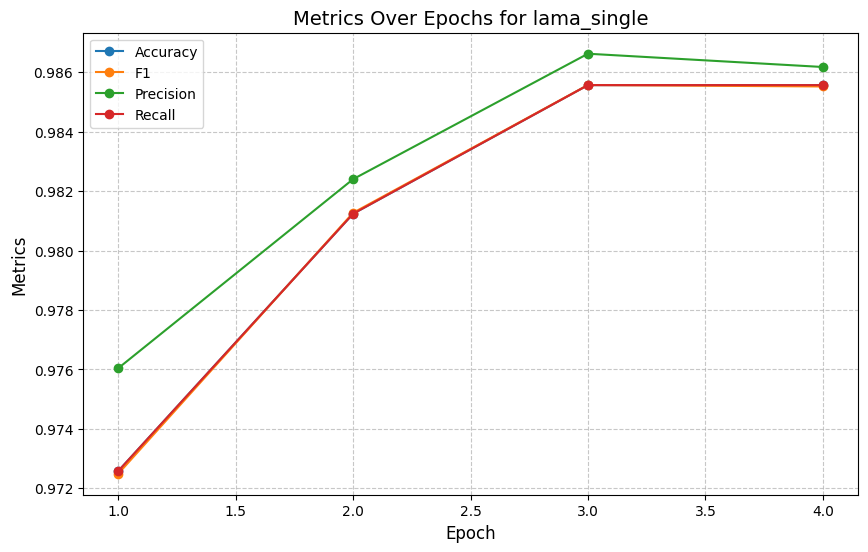

Plot saved at ./metrics_plot_lama_single.png
Processing distilbert_multi...
    epoch  Training Loss  Validation Loss  Accuracy        F1  Precision  \
0     1.0         0.1336         0.142971  0.000000  0.000000   0.000000   
1     2.0         0.0846         0.095580  0.020134  0.111101   0.124518   
2     3.0         0.0765         0.072141  0.167785  0.342173   0.430739   
3     4.0         0.0656         0.057353  0.248322  0.468722   0.539206   
4     5.0         0.0421         0.046828  0.395973  0.661642   0.787505   
5     6.0         0.0328         0.040409  0.483221  0.769182   0.786960   
6     7.0         0.0274         0.033554  0.604027  0.817644   0.860367   
7     8.0         0.0220         0.028655  0.711409  0.899390   0.914661   
8     9.0         0.0302         0.025376  0.691275  0.853895   0.880369   
9    10.0         0.0147         0.022184  0.758389  0.906225   0.948690   
10   11.0         0.0123         0.020992  0.751678  0.897650   0.944955   
11   12.0   

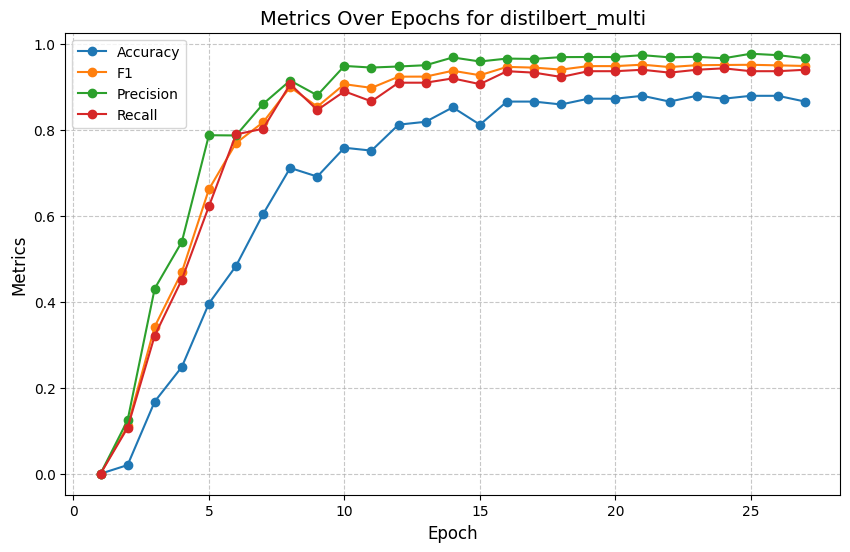

Plot saved at ./metrics_plot_distilbert_multi.png
Processing roberta_multi...
    epoch  Training Loss  Validation Loss  Accuracy        F1  Precision  \
0     1.0         0.1392         0.146601  0.000000  0.000000   0.000000   
1     2.0         0.0932         0.105196  0.067114  0.116710   0.104001   
2     3.0         0.0907         0.085015  0.107383  0.234685   0.256796   
3     4.0         0.0834         0.076250  0.127517  0.236654   0.268159   
4     5.0         0.0660         0.072287  0.154362  0.359803   0.369000   
5     6.0         0.0670         0.066155  0.161074  0.376826   0.411510   
6     7.0         0.0715         0.066405  0.167785  0.377824   0.427340   
7     8.0         0.0587         0.062120  0.214765  0.500293   0.516793   
8     9.0         0.1015         0.058748  0.161074  0.439348   0.504856   
9    10.0         0.0517         0.057982  0.214765  0.468044   0.512239   
10   11.0         0.0532         0.054598  0.201342  0.530627   0.608887   
11   12.0 

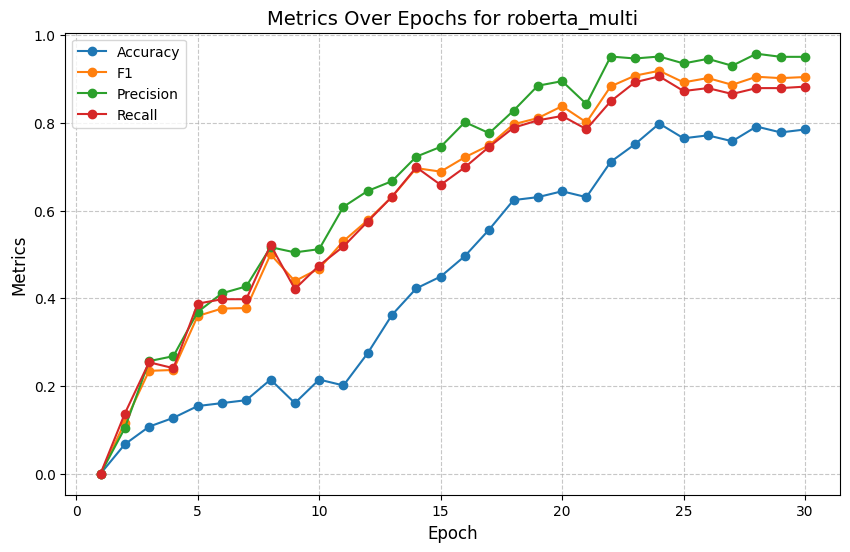

Plot saved at ./metrics_plot_roberta_multi.png


In [ ]:
# Function to plot metrics for a single CSV file
def plot_metrics(csv_path, model_name):
    # Load the CSV file
    try:
        metrics_df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error loading {csv_path}: {e}")
        return

    print(metrics_df)

    # Check if there
    required_columns = ["epoch", "Accuracy", "F1", "Precision", "Recall"]
    for col in required_columns:
        if col not in metrics_df.columns:
            print(f"Missing column {col} in {csv_path}")
            return

    # Plot metrics
    plt.figure(figsize=(10, 6))

    # Plot each metric
    plt.plot(metrics_df["epoch"], metrics_df["Accuracy"], label="Accuracy", marker="o")
    plt.plot(metrics_df["epoch"], metrics_df["F1"], label="F1", marker="o")
    plt.plot(metrics_df["epoch"], metrics_df["Precision"], label="Precision", marker="o")
    plt.plot(metrics_df["epoch"], metrics_df["Recall"], label="Recall", marker="o")

    # Add labels, title, and legend
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Metrics", fontsize=12)
    plt.title(f"Metrics Over Epochs for {model_name}", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.7)

    # Save the plot
    plot_path = f"./metrics_plot_{model_name}.png"
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()
    print(f"Plot saved at {plot_path}")

# Iterate through all and generate plots
for model_name, csv_path in csv_paths.items():
    print(f"Processing {model_name}...")
    plot_metrics(csv_path, model_name)

## Hamming Loss Multi_select

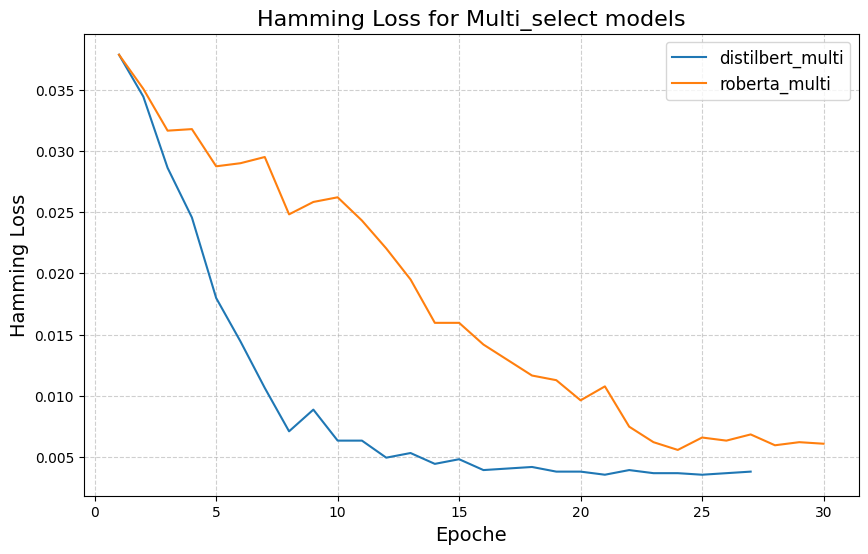

In [26]:
# function Hamming Loss plot

def plot_hamming_loss(models, title):
    plt.figure(figsize=(10, 6))
    for model_name, csv_path in models.items():
        try:
            # read and extract data
            df = pd.read_csv(csv_path)
            epochs = df['epoch']
            hamming_loss = df['Hamming Loss']

            # plot
            plt.plot(epochs, hamming_loss, label=model_name)
        except Exception as e:
            print(f"Error {csv_path} for {model_name}: {e}")

    plt.title(title, fontsize=16)
    plt.xlabel("Epoche", fontsize=14)
    plt.ylabel("Hamming Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# plot
plot_hamming_loss(multi_models, "Hamming Loss for Multi Select Models")

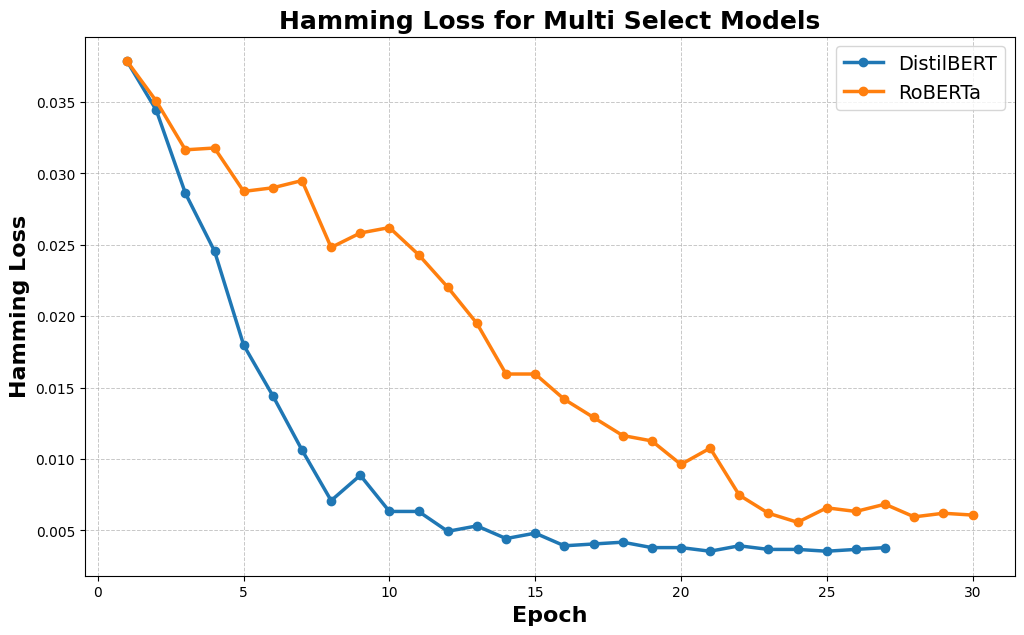

In [29]:
def plot_hamming_loss(models, title):
    plt.figure(figsize=(12, 7))

    # Mapping model names to custom legend labels
    legend_mapping = {
        "distilbert_multi": "DistilBERT",
        "roberta_multi": "RoBERTa"
    }

    for model_name, csv_path in models.items():
        try:
            # Read and extract data
            df = pd.read_csv(csv_path)
            epochs = df['epoch']
            hamming_loss = df['Hamming Loss']

            # Get custom legend name (default to model_name if not in mapping)
            legend_name = legend_mapping.get(model_name, model_name)

            # Plot
            plt.plot(epochs, hamming_loss, label=legend_name, linewidth=2.5, marker='o', markersize=6)

        except Exception as e:
            print(f"Error reading {csv_path} for {model_name}: {e}")

    # Title and labels
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel("Epoch", fontsize=16, fontweight='bold')
    plt.ylabel("Hamming Loss", fontsize=16, fontweight='bold')

    # Legend
    plt.legend(fontsize=14, loc='upper right')

    # Grid styling
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    # Save figure
    save_path = f"drive/MyDrive/CapStone_models/hamming_loss.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality save

    # Show the plot
    plt.show()

# Plot
plot_hamming_loss(multi_models, "Hamming Loss for Multi Select Models")


## Jaccard Similarity Multi_select

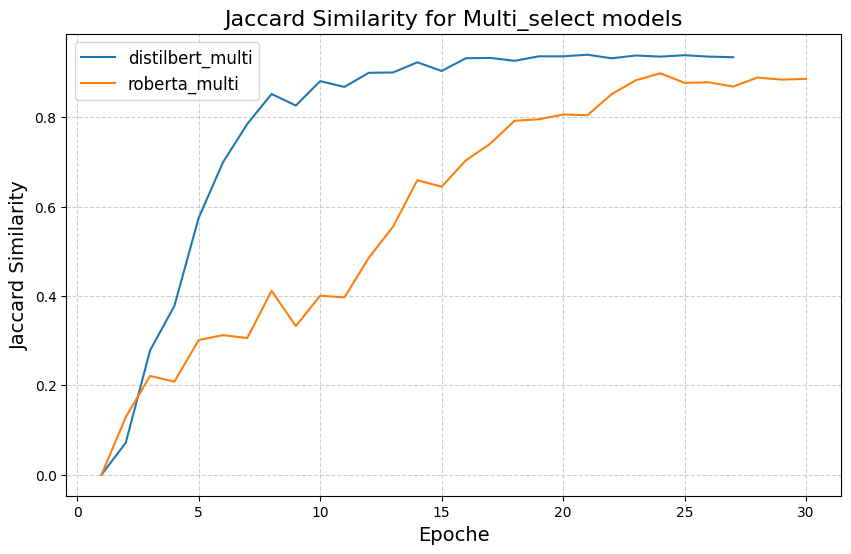

In [ ]:
# function Jaccard Similarity plot

def plot_jaccard_similarity(models, title):
    plt.figure(figsize=(10, 6))
    for model_name, csv_path in models.items():
        try:
            # read and extract data
            df = pd.read_csv(csv_path)
            epochs = df['epoch']
            jaccard = df['Jaccard Similarity']

            # plot
            plt.plot(epochs, jaccard, label=model_name)
        except Exception as e:
            print(f"Error {csv_path} for {model_name}: {e}")

    plt.title(title, fontsize=16)
    plt.xlabel("Epoche", fontsize=14)
    plt.ylabel("Jaccard Similarity", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# plot
plot_jaccard_similarity(multi_models, "Jaccard Similarity for Multi_select models")

## Matthews Correlation Coefficient Multi_select

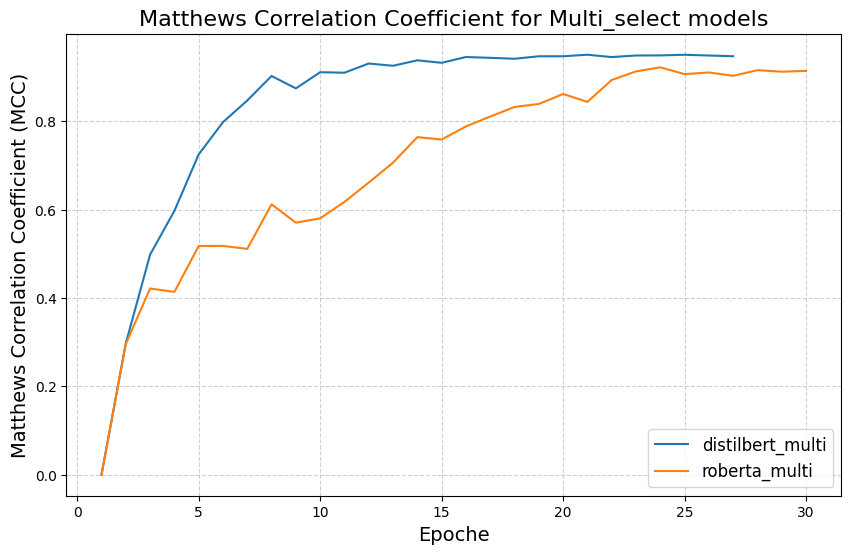

In [ ]:
# function MCC plot

def plot_mcc(models, title):
    plt.figure(figsize=(10, 6))
    for model_name, csv_path in models.items():
        try:
            # read and extract data
            df = pd.read_csv(csv_path)

            epochs = df['epoch']
            mcc = df['Matthews Correlation Coefficient']

            # plot
            plt.plot(epochs, mcc, label=model_name)
        except Exception as e:
            print(f"Error {csv_path} for {model_name}: {e}")

    plt.title(title, fontsize=16)
    plt.xlabel("Epoche", fontsize=14)
    plt.ylabel("Matthews Correlation Coefficient (MCC)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# plot
plot_mcc(multi_models, "Matthews Correlation Coefficient for Multi_select models")

## Dashboard interactive Evaluation DistilBERT vs Roberta

If not already done, please upload the final Q&A datasets for single and multi select.

In [ ]:
# load question data sets (only if saved on colab)
#single_dataset_path = "/content/drive/MyDrive/CapStone_models/final_single_question_data.json"
#multi_dataset_path = "/content/drive/MyDrive/CapStone_models/final_multi_question_data.json"

single_dataset_path = "./final_single_question_data.json"
multi_dataset_path = "./final_multi_question_data.json"

# json files load
with open(single_dataset_path, "r") as file:
    single_dataset = json.load(file)

with open(multi_dataset_path, "r") as file:
    multi_dataset = json.load(file)


# extract questions from datasets
def extract_questions(dataset):

    return [item["question"] for item in dataset if "question" in item]

single_questions = extract_questions(single_dataset)
multi_questions = extract_questions(multi_dataset)

# combine question + type
all_questions = [(q, "single") for q in single_questions] + [(q, "multi") for q in multi_questions]
# return random question
def get_random_question():
    return random.choice(all_questions)

# load models and tokenizer
model_paths = {
    "distilbert_single": "/content/drive/MyDrive/CapStone_models/distilbert_classification_single_select",
    "roberta_single": "/content/drive/MyDrive/CapStone_models/roberta_classification_single_select",
    "distilbert_multi": "/content/drive/MyDrive/CapStone_models/distilbert_classification_multi_select",
    "roberta_multi": "/content/drive/MyDrive/CapStone_models/roberta_classification_multi_select"
}

models = {key: AutoModelForSequenceClassification.from_pretrained(path) for key, path in model_paths.items()}
tokenizers = {key: AutoTokenizer.from_pretrained(path) for key, path in model_paths.items()}

# load label mappings
single_label_mapping_path = "/content/drive/MyDrive/CapStone_models/label_mapping_single_select.pkl"
multi_label_mapping_path = "/content/drive/MyDrive/CapStone_models/label_mapping_multi_wQ.pkl"

with open(single_label_mapping_path, "rb") as file:
    single_label_mapping = pickle.load(file)

#print(single_label_mapping)

single_label_mapping = {int(k.replace('LABEL_', '')): v for k, v in single_label_mapping.items()}

#print(single_label_mapping)

with open(multi_label_mapping_path, "rb") as file:
    multi_label_mapping = pickle.load(file)

# define UI
def on_new_question(b):

    question, question_type = get_random_question()
    question_text.value = f"{question}||{question_type}"
    answer_text.value = ""
    output_label.value = "Waiting for input..."
    with heatmap_output:
        heatmap_output.clear_output()

def on_predict(b):

    question_with_type = question_text.value
    if "||" not in question_with_type:
        output_label.value = "Invalid input format. Please reload a question."
        return

    question, question_type = question_with_type.split("||")
    answer = answer_text.value

    predictions, heatmaps = predict_answer(question, answer, question_type)

    output_label.value = (
        f"<b>Question Type:</b> {question_type.capitalize()}<br>"
        f"<b>DistilBERT Prediction:</b> {', '.join(predictions['distilbert_single' if question_type == 'single' else 'distilbert_multi'])}<br>"
        f"<b>Roberta Prediction:</b> {', '.join(predictions['roberta_single' if question_type == 'single' else 'roberta_multi'])}"
    )

    # Display heatmaps
    with heatmap_output:
        heatmap_output.clear_output()
        display(widgets.HBox([
            widgets.Image(value=heatmaps["distilbert_single" if question_type == "single" else "distilbert_multi"], format="png", width=600, height=300),
            widgets.Image(value=heatmaps["roberta_single" if question_type == "single" else "roberta_multi"], format="png", width=600, height=300)
        ]))

# create heatmaps
def create_heatmap(probabilities, label_mapping, title="Heatmap"):

    plt.figure(figsize=(12, 4))
    labels = [label_mapping[idx] for idx in range(len(label_mapping))]
    plt.imshow([probabilities], cmap="YlGnBu", aspect="auto")
    plt.colorbar(label="Probability")
    plt.yticks([])
    plt.xticks(range(len(probabilities)), labels, rotation=90)
    plt.title(title)

    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    image_bytes = buf.read()
    buf.close()
    plt.close()
    return image_bytes

# predict function
def predict_answer(question, answer, question_type, multi_threshold=0.3):

    model_keys = [
        "distilbert_single" if question_type == "single" else "distilbert_multi",
        "roberta_single" if question_type == "single" else "roberta_multi"
    ]
    label_mapping = single_label_mapping if question_type == "single" else multi_label_mapping

    predictions = {}
    heatmaps = {}

    for model_key in model_keys:
        tokenizer = tokenizers[model_key]
        model = models[model_key]
        inputs = tokenizer(question, answer, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        model.eval()

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.sigmoid(logits).squeeze().tolist()

            if question_type == "single":
                predicted_index = torch.argmax(torch.tensor(probabilities)).item()
                predicted_labels = [label_mapping.get(predicted_index, f"Unknown ({predicted_index})")]
            else:
                predicted_indices = [idx for idx, prob in enumerate(probabilities) if prob > multi_threshold]
                predicted_labels = [label_mapping.get(idx, f"Unknown ({idx})") for idx in predicted_indices]

            predictions[model_key] = predicted_labels if predicted_labels else "No Labels predicted"
            heatmaps[model_key] = create_heatmap(probabilities, label_mapping, title=f"{model_key} Heatmap")

    return predictions, heatmaps

# set up UI
question_text = widgets.Text(description="Question:", layout=widgets.Layout(width="80%"))
answer_text = widgets.Text(description="Answer:", layout=widgets.Layout(width="80%"))
predict_button = widgets.Button(description="Predict")
new_question_button = widgets.Button(description="New Question")
output_label = widgets.HTML(value="Waiting for input...")
heatmap_output = widgets.Output()

predict_button.on_click(on_predict)
new_question_button.on_click(on_new_question)

# Load initial question
on_new_question(None)

# Display UI
display(widgets.VBox([
    question_text,
    answer_text,
    widgets.HBox([predict_button, new_question_button]),
    output_label,
    heatmap_output
]))